# West Nile Virus Prediction

# Table of Contents
1. [Introduction](#intro)
2. [Data](#importdata)
3. [Feature Selection I: EDA](#featureselection)  
4. [Feature Section II: Statistical Overview](#corr)   
    4.1 [Hypothesis testing on the two distributions of each feature](#kstest)   
    4.2 [Pearson correlation & Heatmap](#pearson)   
    
5. [Feature Engineering](#featureeng)  
    5.1 [One-Hot Encoding](#dummies)  
    5.2 [Train/Test data split](#split)  
    5.3 [Imputing missing values](#imputing)  
    5.4 [Feature Scaling](#scaling)  
    5.5 [PCA visualization of the train data](#pca)   
6. [Modeling](#modeling)  

7. [Conclusion](#conclusion)



In [1]:
# Import packages & libraries 
import os
import pandas as pd
from pandas import Series, DataFrame
#import pandas_profiling

pd.set_option('display.max_rows', None,'display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer, roc_auc_score,accuracy_score, roc_curve
from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti

from sklearn.preprocessing import Imputer, StandardScaler
#from sklearn import cross_validation
from sklearn import metrics

"""
from sklearn import metrics
from sklearn import linear_model

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import preprocessing
"""

# ignore Deprecation Warning
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning) 
warnings.filterwarnings("ignore") 

#plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

import missingno as msno


# 1. Introduction
<a id="intro"></a>

West Nile virus (Wnv) is most commonly spread to humans through infected mosquitos. ~20% of people who become infected with wnv develop symptoms ranging from a persistent fever, to serious neurological illness that can result in death. 

The City of Chicago established a comprehensive surveillance and control program. Every week from late spring through the Fall, mosquitos in traps across the city are tested for wnv. The results can then be used to help make decisions about when and where the city should spray airborne pesticides to control adult mosquito populations. 

The objective of this project is to use the available datasets (weather, location, testing and spraying data) to build a model that can predict when and where different species of mosquitos will test positive for wmv. This can help the City of Chicago more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

# 2. Data
<a id="importdata"></a>

In this project, I will work with the publicly available data on Kaggle

spray.csv:
- GIS data of spraying efforts in 2011 and 2013
- Date, Time: the date and time of the spray
- Latitude, Longitude: the Latitude and Longitude of the spray

train.csv & test.csv:

- The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set one is requested to predict the test results for 2008, 2010, 2012, and 2014.

- Id: the id of the record
- Date: date that the WNV test is performed
- Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
- Species: the species of mosquitos
- Block: block number of address
- Street: street name
- Trap: Id of the trap
- AddressNumberAndStreet: approximate address returned from GeoCoder
- Latitude, Longitude: Latitude and Longitude returned from GeoCoder
- AddressAccuracy: accuracy returned from GeoCoder
- NumMosquitos: number of mosquitoes caught in this trap
- WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

weather.csv:
- weather data from 2007 to 2014. 
- Column descriptions in noaa_weather_qclcd_documentation.pdf. 


In [2]:
df_spray = pd.read_csv('./all/spray.csv',low_memory=True)
df_train = pd.read_csv('./all/train.csv',low_memory=True)
df_test = pd.read_csv('./all/test.csv',low_memory=True)
df_weather = pd.read_csv('./all/weather.csv',low_memory=True)

For the sake of clarity, I will explore each dataset individually and then consider possibly combining them to make a master dataframe for making the predictions. 

## 2.1 Spray Data

In [3]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [4]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [5]:
df_spray.head(2)

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163

In [6]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [7]:
missing_values_table(df_spray)

Your selected dataframe has 4 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values    type
Time             584                3.9  object

There are missing data (4%) in the "Time". This column is of little importance. "Date" is more important. I will just fill in with the mode value. 

In [8]:
df_spray['Time'].fillna(df_spray['Time'].mode()[0], inplace=True)
missing_values_table(df_spray)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values, type]
Index: []

<span style="color:red">Thoughts:</span> 

The spraying could reduce the number of mosquitos in the area, and therefore might eliminate the appearance of Wnv.
However, I could imagine several difficulties in applying this dataset. 


- Time: 
    - Need to check the spraying dates and the trap allocation dates. Which one happens first and how far these two dates are apart? How long each spraying will be lasting? one week from the spraying day? 
    - In addition, there is only spraying data in 2011 and 2013. If I am going to include this feature into my final data frame for modeling, how should I deal with the missing data?

- Location: 
    - what's the effective area? say, a circular area, centered at the spraying location, with a radius of 1 mile?

- But, if I just want to have a first-order check/comparison of the spraying data and the main trap data then probably I can just plot both in to geographic maps and eye-ball their overlaps, etc.

- Further, if I could make a gif/animation about how the maps with both trap and spraying locations change with time, that might be very helpful.

In [9]:
#df_spray.Date = pd.datetime(df_spray.Date)
df_spray.Date.value_counts().sort_index()

2011-08-29      95
2011-09-07    2114
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: Date, dtype: int64

There were only 2 spraying days in 2011 and 8 spraying days in 2013. It's hard to tell each of the spraying was after which testing day. The spraying data is of little help. 

In [10]:
df_spray.sample(5)

Date         Time   Latitude  Longitude
8323   2013-08-15   8:53:06 PM  41.895535 -87.766700
8077   2013-08-15  11:35:18 PM  41.951178 -87.778508
4991   2013-07-25   8:20:40 PM  41.966738 -87.717118
5935   2013-07-25  10:01:26 PM  41.958990 -87.730882
14560  2013-09-05   8:32:36 PM  42.005385 -87.809592

Now the spraying data is clean. 

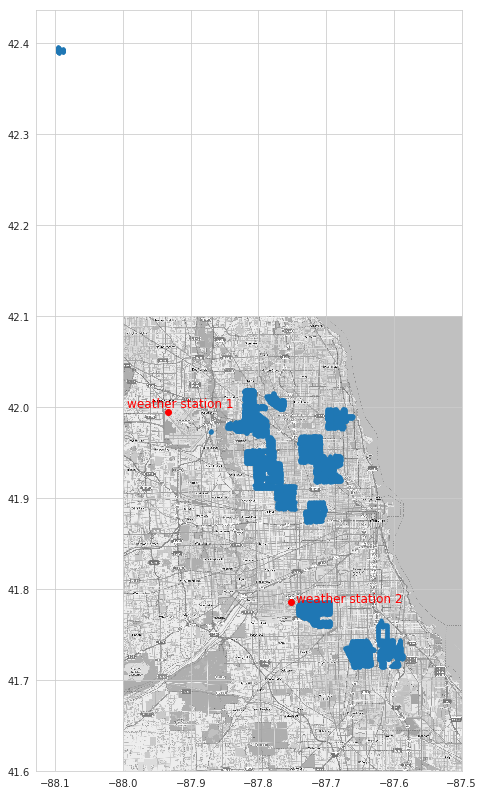

In [11]:
import matplotlib.tri as tri

# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("all/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

#mapimg = './chicago.png'
#traps = pd.read_csv('../input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = df_spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='.')
                
# weather station
plt.scatter( [-87.933, -87.752], [41.995, 41.786], marker = 'o', color='red')
plt.text(-87.994, 42, 'weather station 1', fontsize=12, color = 'red')
plt.text(-87.745, 41.786, 'weather station 2', fontsize=12, color = 'red')

# Add this when copying to a script on Kaggle:
plt.savefig('./output/spraymap.png', dpi=300)

One of the spraying locations is out of Chicago...probably human errors/typos. I will remove this point. 

In [12]:
i = df_spray.index[df_spray.Latitude > 42.1]
df_spray.drop(i, axis=0, inplace=True)

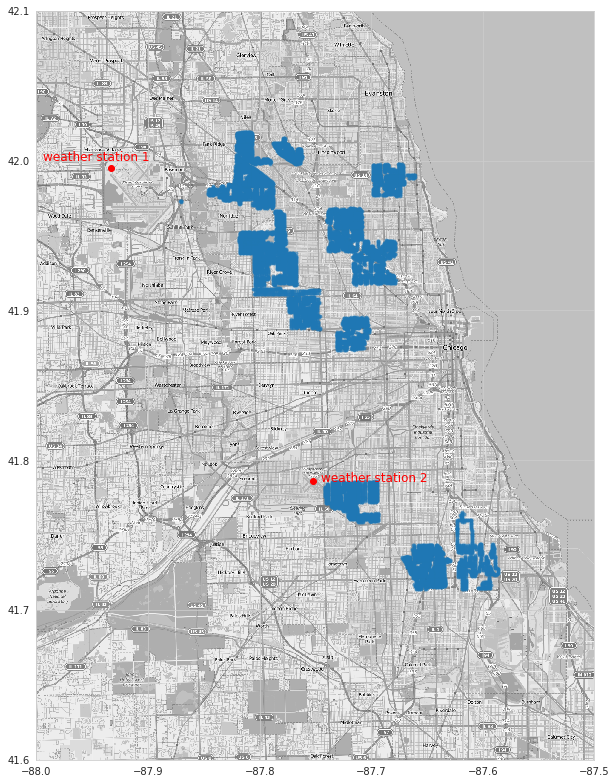

In [13]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("all/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

#mapimg = './chicago.png'
#traps = pd.read_csv('../input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = df_spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='.', alpha = 0.5)
                
# weather station
plt.scatter( [-87.933, -87.752], [41.995, 41.786], marker = 'o', color='red')
plt.text(-87.994, 42, 'weather station 1', fontsize=12, color = 'red')
plt.text(-87.745, 41.786, 'weather station 2', fontsize=12, color = 'red')

# Add this when copying to a script on Kaggle:
plt.savefig('./output/spraymap.png', dpi=300)

14740 12626


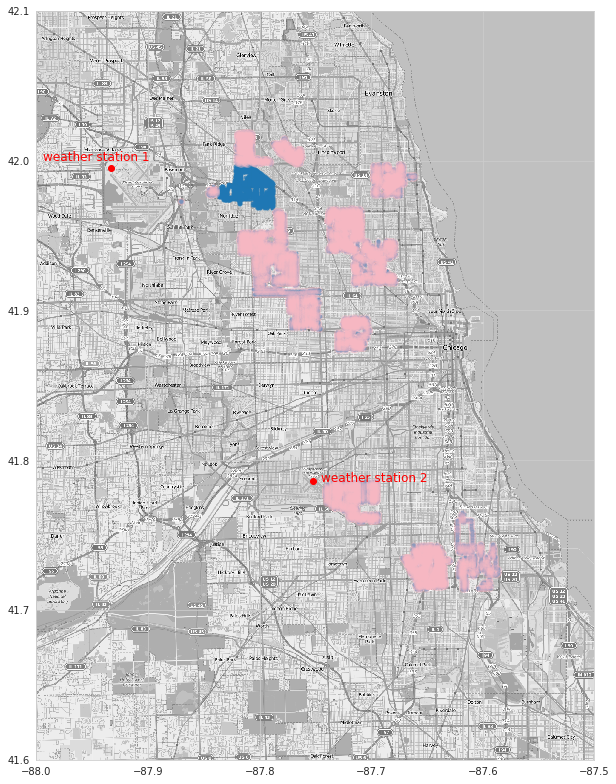

In [14]:
mapdata = np.loadtxt("all/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

df_spray11 = df_spray[df_spray['Date'] >= '2011']
df_spray13 = df_spray[df_spray['Date'] >= '2013']

print(df_spray11.Date.value_counts().sum(), df_spray13.Date.value_counts().sum())

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = df_spray11[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='.', alpha = 0.5)
locations = df_spray13[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='o', alpha = 0.1, color='pink')
  
    
# weather station
plt.scatter( [-87.933, -87.752], [41.995, 41.786], marker = 'o', color='red')
plt.text(-87.994, 42, 'weather station 1', fontsize=12, color = 'red')
plt.text(-87.745, 41.786, 'weather station 2', fontsize=12, color = 'red')

# Add this when copying to a script on Kaggle:
plt.savefig('./output/spraymap_2011.png', dpi=300)

--------------------------------------------------------------------------------
Species of Misquito:
['CULEX ERRATICUS' 'CULEX PIPIENS' 'CULEX PIPIENS/RESTUANS'
 'CULEX RESTUANS' 'CULEX SALINARIUS' 'CULEX TARSALIS' 'CULEX TERRITANS']
--------------------------------------------------------------------------------
SKIPPING [1]:2007 (CULEX ERRATICUS)		No sightings
SKIPPING [2]:2009 (CULEX ERRATICUS)		No sightings
SKIPPING [3]:2011 (CULEX ERRATICUS)		No sightings
         [4]:2013 (CULEX ERRATICUS)
         [5]:2007 (CULEX PIPIENS)
         [6]:2009 (CULEX PIPIENS)
         [7]:2011 (CULEX PIPIENS)
         [8]:2013 (CULEX PIPIENS)
         [9]:2007 (CULEX PIPIENS/RESTUANS)
         [10]:2009 (CULEX PIPIENS/RESTUANS)
         [11]:2011 (CULEX PIPIENS/RESTUANS)
         [12]:2013 (CULEX PIPIENS/RESTUANS)
         [13]:2007 (CULEX RESTUANS)
         [14]:2009 (CULEX RESTUANS)
         [15]:2011 (CULEX RESTUANS)
         [16]:2013 (CULEX RESTUANS)
         [17]:2007 (CULEX SALINARIUS)
     

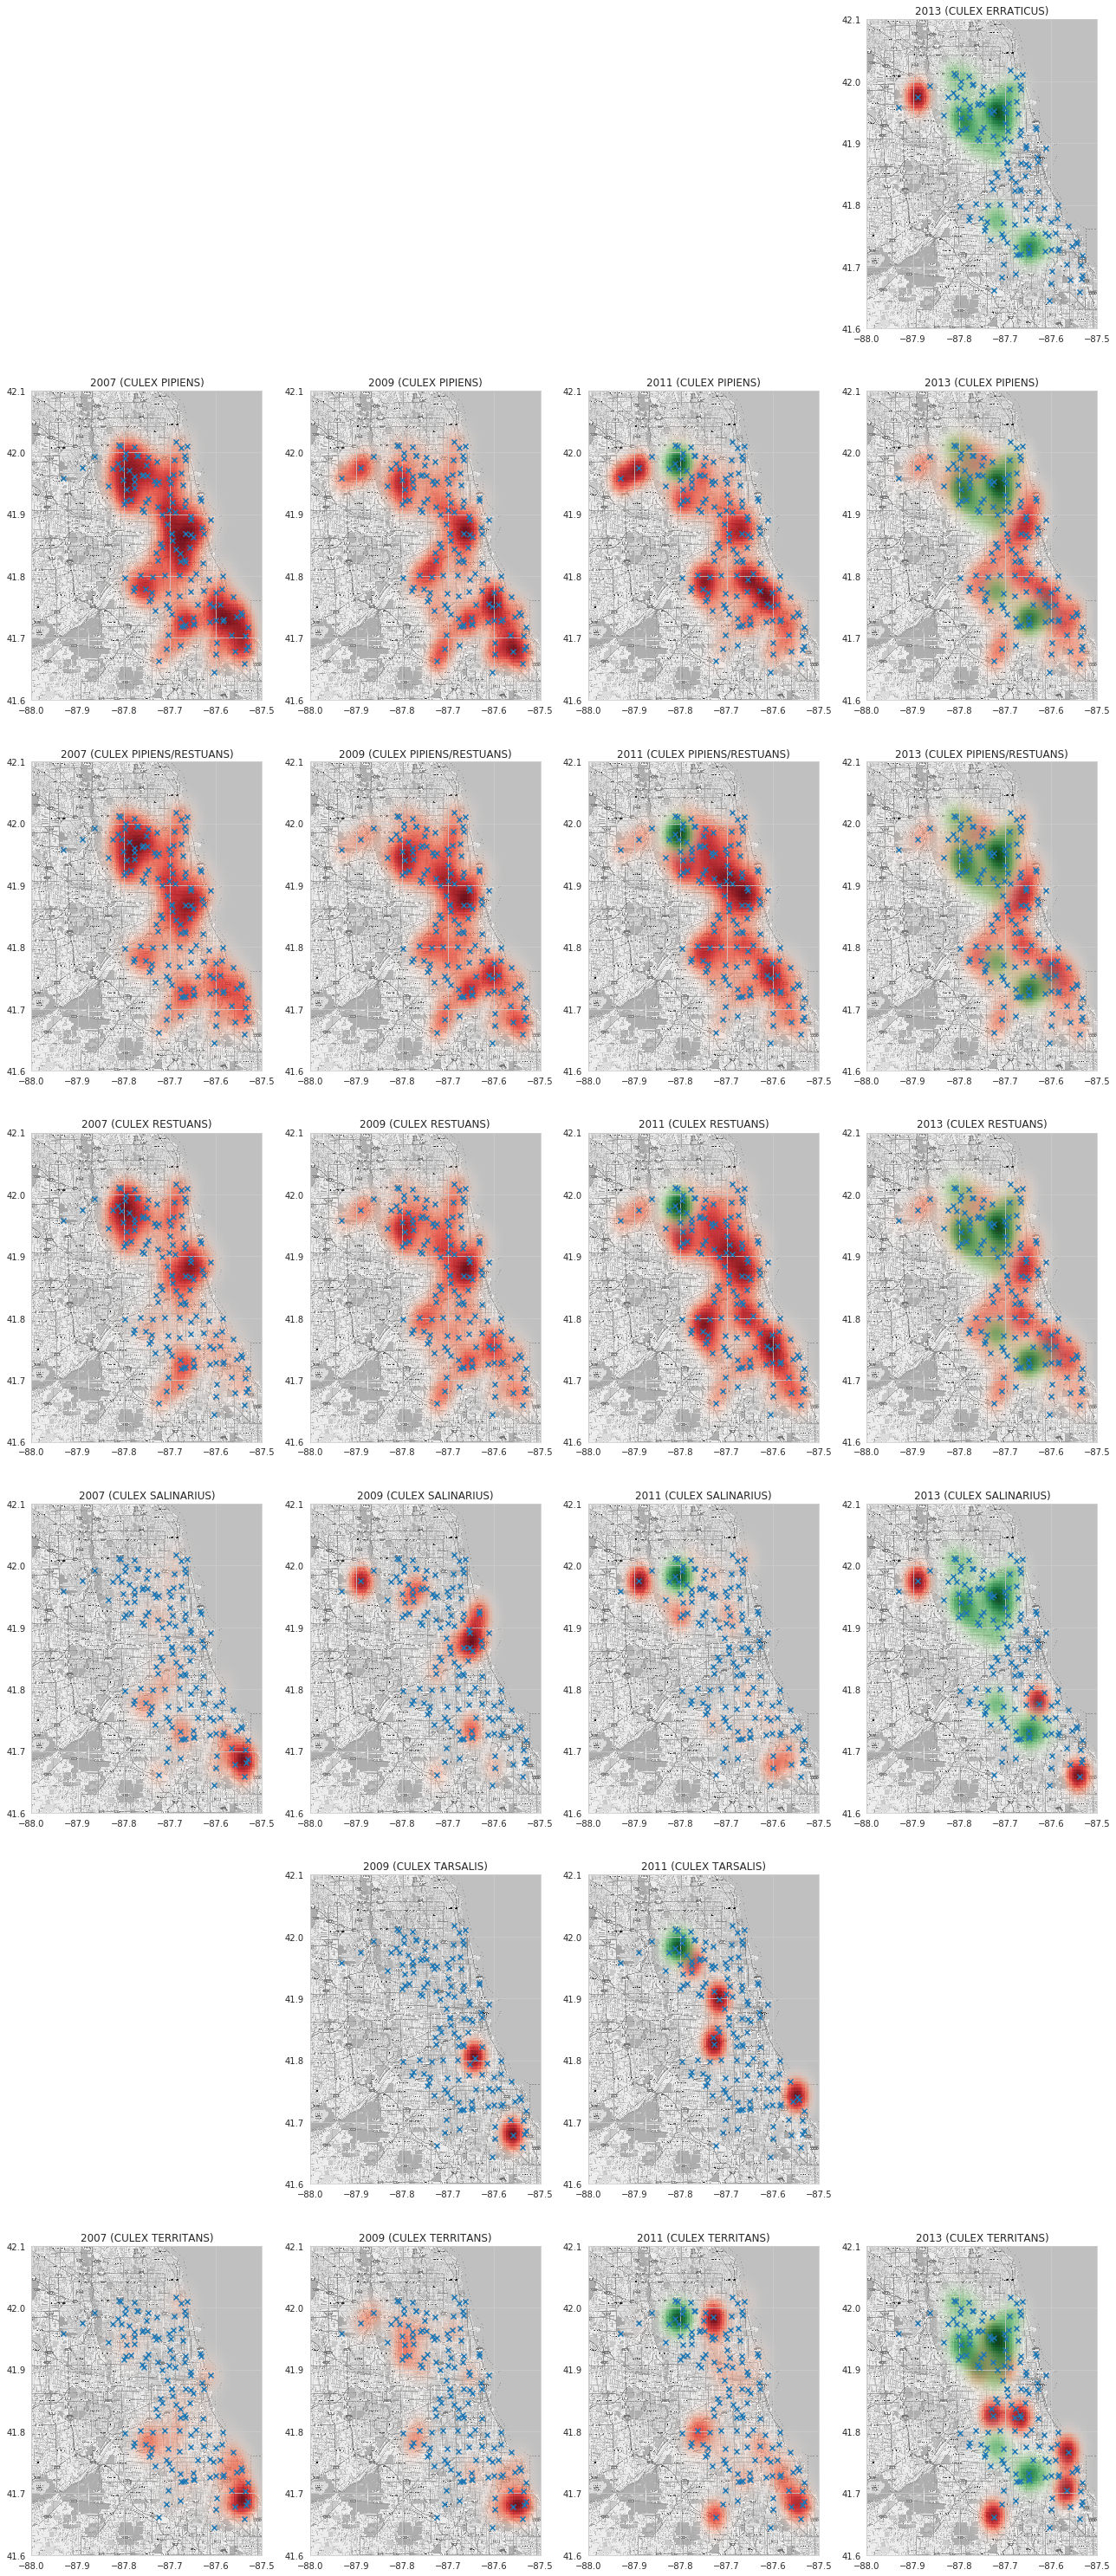

In [15]:
import pandas
from sklearn.neighbors import KernelDensity

#--Functions---------------------------------------------------------------------
def plotHeatMap(data, a_cm):
    if(len(data) > 0):
        X = data[['Longitude', 'Latitude']].values
        kd = KernelDensity(bandwidth=0.02)
        kd.fit(X)
        xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(),yv.ravel()]).T
        zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
        plt.imshow(zv, 
                   origin='lower', 
                   cmap=a_cm, 
                   extent=lon_lat_box, 
                   aspect=aspect)
#--------------------------------------------------------------------------------


print("--------------------------------------------------------------------------------")
train = pandas.read_csv("./all/train.csv")
species = pandas.np.unique(train['Species'])
print("Species of Misquito:")
print(species)
spray = pandas.read_csv("./all/spray.csv", parse_dates=['Date'])
weather = pandas.read_csv("./all/weather.csv")
print("--------------------------------------------------------------------------------")

traps = pandas.read_csv('./all/train.csv', parse_dates=['Date'])[['Date', 'Trap','Longitude', 'Latitude', 'Species', 'WnvPresent']]
mapdata = np.loadtxt("./all/mapdata_copyright_openstreetmap_contributors.txt")

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
alpha_mcm = plt.cm.Greens
alpha_mcm._init()
alpha_mcm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

subplot = 0
numSpcs = len(species)
plt.figure(figsize=(18,6*numSpcs))
for spcsIndx in range(numSpcs):
    for year in [2007, 2009, 2011, 2013]:
        subplot += 1
        sightings = spray[(spray['Date'].apply(lambda x: x.year) == year)]
        mSightings = traps[(traps['Species'] == species[spcsIndx])
                          & (traps['Date'].apply(lambda x: x.year) == year)]
        mSightings = mSightings.groupby(['Date', 'Trap', 'Longitude', 'Latitude', 'Species']).max()['WnvPresent'].reset_index()
        if(len(mSightings) <= 0):
            print("SKIPPING [" + str(subplot) + "]:" + str(year) + " (" + species[spcsIndx] + ")\t\tNo sightings")
            continue

        plt.subplot(numSpcs, 4, subplot)
        plt.gca().set_title(str(year) + " (" + species[spcsIndx] + ")")
        plt.imshow(mapdata, 
                   cmap=plt.get_cmap('gray'), 
                   extent=lon_lat_box, 
                   aspect=aspect)
        plotHeatMap(mSightings, alpha_cm)#trap, red
        plotHeatMap(sightings, alpha_mcm)#spray, green

        print("         [" + str(subplot) + "]:" + str(year) + " (" + species[spcsIndx] + ")")
        plt.tight_layout()
        locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
        plt.scatter(locations[:,0], locations[:,1], marker='x')

plt.savefig('heatmap.png')


## 2.2 Weather Data

The dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests are provided. Detailed column descriptions are provided in noaa_weather_qclcd_documentation.pdf, below I only list a few important/relevant ones. 

Temperature: in F

Tmax: Maximum

Tmin: Minimum

**Tavg**: Average

Depart: Departure from normal

DewPoint: Average Dew Point

WebBulb: Average Wet Bulb

Degree Days: Base 65 F, relative to Tavg

Heat: HEATING (SEASON BEGINS WITH JULY)

Cool: COOLING (SEASON BEGINS WITH JANUARY)

Station 2 has no records in sunrise and sunset.

SUNRISE  (Calculated, not observed)

SUNSET   (Calculated, not observed)


Significant Weather Types:

Weather Phenomena: 

+FC TORNADO/WATERSPOUT

 FC  FUNNEL CLOUD
 
 TS  THUNDERSTORM
 
 GR  HAIL
 
 RA RAIN ...
 
**PrecipTotal**: INCHES (24-HR PERIOD ENDING AT INDICATED LOCAL STANDARD TIME)


M = Missing Data, or data that are not normally reported for the station.

T = TRACE

"-" = values not available for sunrise/sunset.

In [16]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [17]:
df_weather.head(5)

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   
3       -      -   BR HZ     M      M        M        0.00       29.44   
4    0446   1851             0      M      0.0        0.00       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

The weather data is a bit messy. There are missing values (Stored as "M"), wrong formatted values ("   T"), etc. 


Each date has 2 records, one for each station. Since I am planning to join this dataset to the training data on the date, I decide to merge the 2 station records together. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

There should be little difference for the weather measurements between these two stations. In fact, that's what I see from the data. 

But, there are some infomation that station 2 always fails to collect. Therefore, i will just use the data from station 1. 

<span style="color:red">Thoughts:</span> 
Well, the best solution would be somehow average the information from the 2 stations. This could be something that I could do if I find that higher accuracy is required or there is significant difference between the two stations. 

In [18]:
df_weather = df_weather.replace({'M':np.NaN, 'T':0., '-':np.NaN, '  T':0., ' ':np.NaN})

In [19]:
missing_values_table(df_weather[df_weather['Station'] == 2])

Your selected dataframe has 22 columns.
There are 15 columns that have missing values.


Missing Values  % of Total Values     type
Depart                 1472              100.0   object
Sunrise                1472              100.0   object
Sunset                 1472              100.0   object
Depth                  1472              100.0   object
Water1                 1472              100.0  float64
SnowFall               1472              100.0   object
CodeSum                 804               54.6   object
Tavg                     11                0.7   object
Heat                     11                0.7   object
Cool                     11                0.7   object
SeaLevel                  4                0.3   object
AvgSpeed                  3                0.2   object
PrecipTotal               2                0.1   object
StnPressure               2                0.1   object
WetBulb                   1                0.1   object

In [20]:
missing_values_table(df_weather[df_weather['Station'] == 1])

Your selected dataframe has 22 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values     type
Water1                 1472              100.0  float64
CodeSum                 805               54.7   object
SeaLevel                  5                0.3   object
WetBulb                   3                0.2   object
StnPressure               2                0.1   object

In [21]:
df_weather_st1 = df_weather[df_weather['Station'] == 1].reset_index(drop=True)

In [22]:
df_weather_st1['CodeSum'].value_counts().head(20)

RA               161
RA BR            128
BR                66
TSRA RA BR        48
RA DZ BR          31
BR HZ             30
TSRA RA           21
TSRA              14
HZ                13
RA BR HZ          12
TS TSRA RA BR     12
TSRA BR           10
RA HZ              9
RA DZ              8
TS TSRA            6
TS                 6
DZ BR              6
TSRA RA BR HZ      6
TS TSRA BR         5
TS RA              5
Name: CodeSum, dtype: int64

Now, it's the feature selection part. Obviously, I will drop "Water1", which is supposed to be "water equivalent" in the pdf file. 

<span style="color:red">Thoughts:</span> 

Usually I would drop features with > 50% missing values. However, I do realize that it could be helpful information. Especially for "RA" (rain), "BR" (Mist), "TS" (Thunderstorm), they would increase the humidity and may deduce the appearence of mosquitos. Again, if I include it, i will need to think about the missing values in the majority of the observations. I will drop it for now. I may come back to this feature while modeling. 

It is believed that **hot and dry** conditions are more favorable for West Nile virus than cold and wet. So the information about temperature and rain/precipitation is the most important. 

However, i decide to keep other features (wind, sealevel, etc) for EDA. They can be easily dropped if I find them unnecessary or causing curse of dimensionality. 

In [23]:
weather_todrop = ['Station', 'Water1', 'CodeSum', 'Sunrise', 'Sunset', 'Tmax', 'Tmin']
df_weather_st1 = df_weather_st1.drop(columns=weather_todrop)

In [24]:
df_weather_st1.head(1)

Date Tavg Depart  DewPoint WetBulb Heat Cool Depth SnowFall  \
0  2007-05-01   67     14        51      56    0    2     0      0.0   

  PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0        0.00       29.10    29.82          1.7         27      9.2

In [25]:
missing_values_table(df_weather_st1)

Your selected dataframe has 15 columns.
There are 3 columns that have missing values.


Missing Values  % of Total Values    type
SeaLevel                  5                0.3  object
WetBulb                   3                0.2  object
StnPressure               2                0.1  object

In [26]:
tmps = ['SeaLevel', 'WetBulb', 'StnPressure']

In [27]:
for item in tmps:
    df_weather_st1[item].fillna(df_weather_st1[item].mode()[0], inplace=True)

In [28]:
missing_values_table(df_weather_st1)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values, type]
Index: []

In [29]:
df_weather_st1['Date'] = pd.to_datetime(df_weather_st1['Date'])

In [30]:
df_weather_st1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 15 columns):
Date           1472 non-null datetime64[ns]
Tavg           1472 non-null object
Depart         1472 non-null object
DewPoint       1472 non-null int64
WetBulb        1472 non-null object
Heat           1472 non-null object
Cool           1472 non-null object
Depth          1472 non-null object
SnowFall       1472 non-null object
PrecipTotal    1472 non-null object
StnPressure    1472 non-null object
SeaLevel       1472 non-null object
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null int64
AvgSpeed       1472 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(11)
memory usage: 172.6+ KB


In [31]:
tmp = [ 'Tavg',
 'Depart',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'Depth',
 'SnowFall',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed']

In [32]:
df_weather_st1[tmp] = df_weather_st1[tmp].astype('float')

In [33]:
df_weather_st1.head(2)

Date  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  SnowFall  \
0 2007-05-01  67.0    14.0      51.0     56.0   0.0   2.0    0.0       0.0   
1 2007-05-02  51.0    -3.0      42.0     47.0  14.0   0.0    0.0       0.0   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0          0.0        29.10     29.82          1.7       27.0       9.2  
1          0.0        29.38     30.09         13.0        4.0      13.4

In [34]:
df_weather_st1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 15 columns):
Date           1472 non-null datetime64[ns]
Tavg           1472 non-null float64
Depart         1472 non-null float64
DewPoint       1472 non-null float64
WetBulb        1472 non-null float64
Heat           1472 non-null float64
Cool           1472 non-null float64
Depth          1472 non-null float64
SnowFall       1472 non-null float64
PrecipTotal    1472 non-null float64
StnPressure    1472 non-null float64
SeaLevel       1472 non-null float64
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null float64
AvgSpeed       1472 non-null float64
dtypes: datetime64[ns](1), float64(14)
memory usage: 172.6 KB


Not the weather data is all clean and ready to be combined with the main data. Date would be the key for the merge.

## 2.3 train & test data

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [37]:
df_train.head(1)

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  
0             1           0

In [38]:
df_test.head(1)

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

Except for "Id", which is just for Kaggle's submission, there are 2 features missing in the testing data. one is the target variable "WnvPresent" (0/1), the other one is the "NumMosquitos" (capped at 50). 

I will stack the test and train in order to do the same transformations and feature engineering to both. Before training the model, I will split them back.

The train data has a size of 10506 and the test data has the size of 116293! So there will be a lot of missing values of "NumMosquitos" and "WnvPresent".

In [39]:
# Target variable
wnv_present = df_train.WnvPresent
num_mos = df_train.NumMosquitos

In [40]:
df = pd.concat([df_train, df_test.drop(['Id'], axis=1)])

In [41]:
df.tail(2)

Address  AddressAccuracy  \
116291  2100 North Cannon Drive, Chicago, IL 60614, USA                8   
116292  2100 North Cannon Drive, Chicago, IL 60614, USA                8   

                AddressNumberAndStreet  Block        Date   Latitude  \
116291  2100  N CANNON DR, Chicago, IL     21  2014-10-02  41.925652   
116292  2100  N CANNON DR, Chicago, IL     21  2014-10-02  41.925652   

        Longitude  NumMosquitos            Species        Street   Trap  \
116291  -87.63359           NaN  UNSPECIFIED CULEX   N CANNON DR  T054C   
116292  -87.63359           NaN    CULEX ERRATICUS   N CANNON DR  T054C   

        WnvPresent  
116291         NaN  
116292         NaN

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 116292
Data columns (total 12 columns):
Address                   126799 non-null object
AddressAccuracy           126799 non-null int64
AddressNumberAndStreet    126799 non-null object
Block                     126799 non-null int64
Date                      126799 non-null object
Latitude                  126799 non-null float64
Longitude                 126799 non-null float64
NumMosquitos              10506 non-null float64
Species                   126799 non-null object
Street                    126799 non-null object
Trap                      126799 non-null object
WnvPresent                10506 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 12.6+ MB


Address                   False
AddressAccuracy           False
AddressNumberAndStreet    False
Block                     False
Date                      False
Latitude                  False
Longitude                 False
NumMosquitos               True
Species                   False
Street                    False
Trap                      False
WnvPresent                 True
dtype: bool

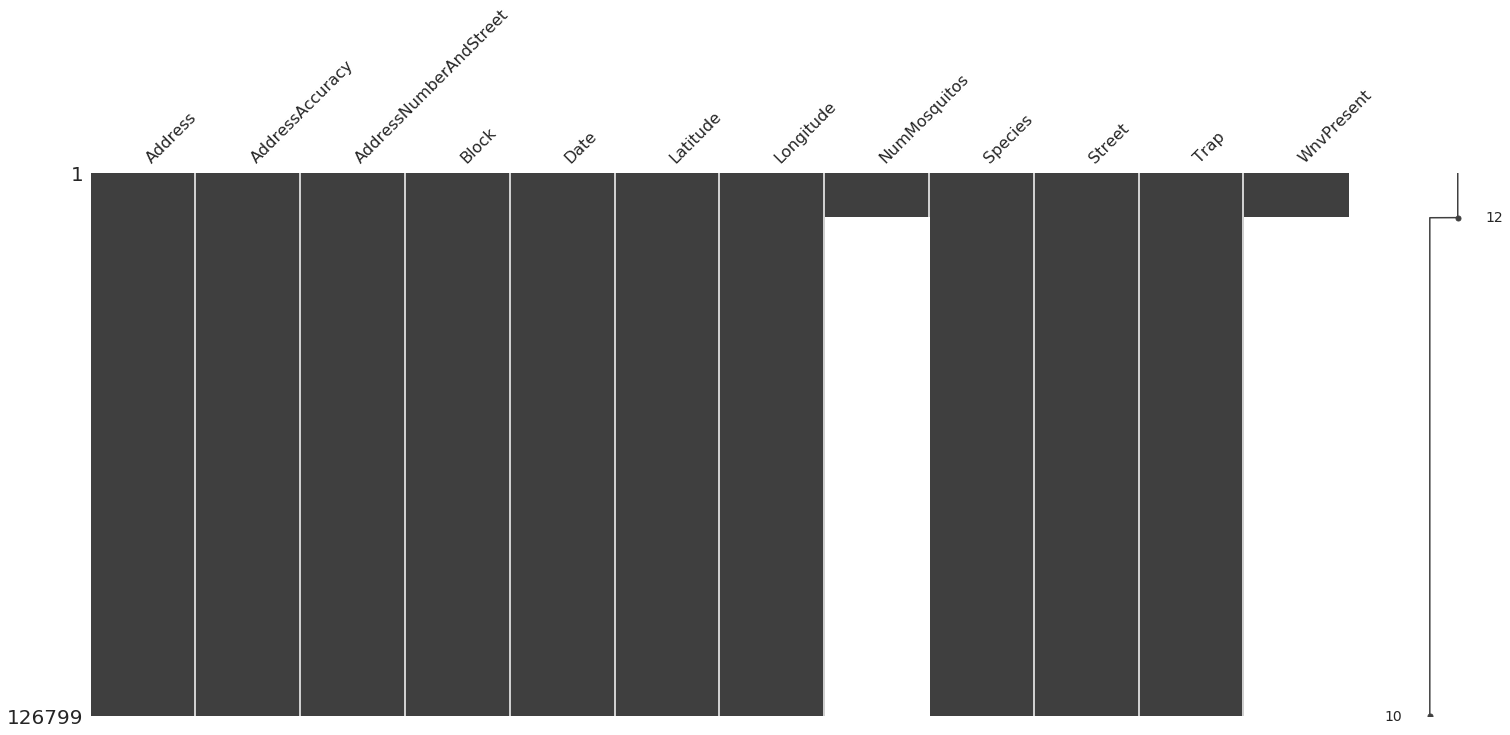

In [43]:
msno.matrix(df)
df.isnull().any()

In [44]:
missing_values_table(df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values     type
NumMosquitos          116293               91.7  float64
WnvPresent            116293               91.7  float64

There are 12 features, with mixed data types, but there are no missing values (except the target variables). I will combine the weather data with it and then I will check each feature individually. 

In [45]:
df.Date = pd.to_datetime(df.Date)

In [46]:
df = pd.merge(df, df_weather_st1, on='Date')

In [47]:
df.head(2)

Address  AddressAccuracy  \
0  4100 North Oak Park Avenue, Chicago, IL 60634,...                9   
1  4100 North Oak Park Avenue, Chicago, IL 60634,...                9   

              AddressNumberAndStreet  Block       Date  Latitude  Longitude  \
0  4100  N OAK PARK AVE, Chicago, IL     41 2007-05-29  41.95469 -87.800991   
1  4100  N OAK PARK AVE, Chicago, IL     41 2007-05-29  41.95469 -87.800991   

   NumMosquitos                 Species           Street  Trap  WnvPresent  \
0           1.0  CULEX PIPIENS/RESTUANS   N OAK PARK AVE  T002         0.0   
1           1.0          CULEX RESTUANS   N OAK PARK AVE  T002         0.0   

   Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  SnowFall  PrecipTotal  \
0  74.0    10.0      58.0     65.0   0.0   9.0    0.0       0.0          0.0   
1  74.0    10.0      58.0     65.0   0.0   9.0    0.0       0.0          0.0   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0        29.39     30.11          5.8       18.0       6.5  
1        29.39     30.11          5.8       18.0       6.5

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 126798
Data columns (total 26 columns):
Address                   126799 non-null object
AddressAccuracy           126799 non-null int64
AddressNumberAndStreet    126799 non-null object
Block                     126799 non-null int64
Date                      126799 non-null datetime64[ns]
Latitude                  126799 non-null float64
Longitude                 126799 non-null float64
NumMosquitos              10506 non-null float64
Species                   126799 non-null object
Street                    126799 non-null object
Trap                      126799 non-null object
WnvPresent                10506 non-null float64
Tavg                      126799 non-null float64
Depart                    126799 non-null float64
DewPoint                  126799 non-null float64
WetBulb                   126799 non-null float64
Heat                      126799 non-null float64
Cool                      126799 non-null f

In [49]:
missing_values_table(df)

Your selected dataframe has 26 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values     type
NumMosquitos          116293               91.7  float64
WnvPresent            116293               91.7  float64

Everything looks good in the master dataframe. Now I will inspect each feature (in the original training data) individually. 

## 3. Feature Selection: EDA
<a id="featureselection"></a>

Note that, during EDA part, I will be very conservative in terms of removing features. As the purpose is to explore any possible patterns/structures in the data, even some of which might not be ultimately useful for modeling. 


In [50]:
# make general plots to examine each feature
def plot_var(df, col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='WnvPresent_str', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by WnvPresent')
    else:
        Charged_Off_rates = df.groupby(col_name)['WnvPresent_str'].value_counts(normalize=True)[:,'Wnv present']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of wnv present')
        ax2.set_title('Wnv pressent Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'WnvPresent_str', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='WnvPresent_str', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

### WnvPresent: **Target Variable**

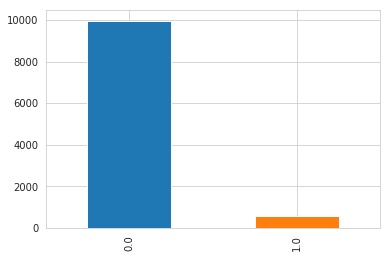

In [51]:
df['WnvPresent'].value_counts().plot.bar()

In [52]:
df['WnvPresent'].value_counts(normalize=True)

0.0    0.947554
1.0    0.052446
Name: WnvPresent, dtype: float64

About 95% (10k) of the Mosquitos are not Wnv carriers and 5% (0.5k) are found to have Wnv. This is an unbalanced classification problem that will need to be taken care of in the modeling. 

### "NumMosquitos"

In [53]:
#df['WnvPresent_str'] = df['WnvPresent'].map(lambda x: 'Wnv Present' if x > 0 else x: 'Wnv not present' if x==0)

#df['WnvPresent_str'] = df['WnvPresent']
#df['WnvPresent_str'].replace(0.0, 'Wnv not present', inplace=True)

#df['WnvPresent_str'].replace(1.0, 'Wnv present', inplace=True)

df['WnvPresent_str'] = df['WnvPresent'].map({0.0: 'Wnv not present', 1.0: 'Wnv present'})


In [54]:
df_train['NumMosquitos'].describe()

count    10506.000000
mean        12.853512
std         16.133816
min          1.000000
25%          2.000000
50%          5.000000
75%         17.000000
max         50.000000
Name: NumMosquitos, dtype: float64

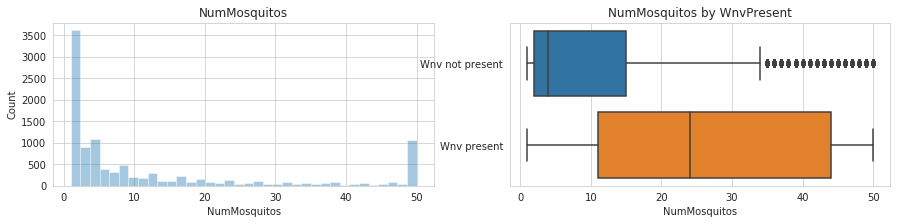

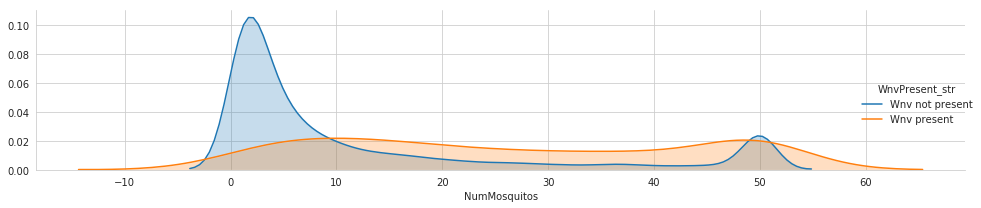

In [55]:
plot_var(df, 'NumMosquitos', 'NumMosquitos', continuous=True)

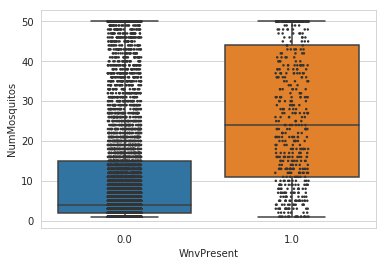

In [56]:
ax = sns.boxplot(x="WnvPresent", y="NumMosquitos", data=df, whis=np.inf)
ax = sns.stripplot(x="WnvPresent", y="NumMosquitos", data=df, jitter=True, size = 5, marker='.', color=".2")

Here I draw strips of observations on top of a box plot. It shows that:

1. there are more mosquitos without WnvPresent
2. The WnvPresent observations have higher mean values of NumMosquitos. That is the more mosquitos, the higher chance of getting Wnv. 
3. The variation of Wnv observations on the NumMosquitos ranges from ~10 to 40

In [57]:
df[['WnvPresent', 'NumMosquitos']].corr()

WnvPresent  NumMosquitos
WnvPresent       1.00000       0.19682
NumMosquitos     0.19682       1.00000

In [58]:
df.loc[290:298]

Address  AddressAccuracy  \
290  1100 West Chicago Avenue, Chicago, IL 60642, USA                8   
291   2200 North Cannon Drive, Chicago, IL 60614, USA                8   
292   2200 North Cannon Drive, Chicago, IL 60614, USA                8   
293    2200 West 113th Street, Chicago, IL 60643, USA                8   
294    2200 West 113th Street, Chicago, IL 60643, USA                8   
295    2200 West 113th Street, Chicago, IL 60643, USA                8   
296    2200 West 113th Street, Chicago, IL 60643, USA                8   
297    2200 West 113th Street, Chicago, IL 60643, USA                8   
298    2200 West 113th Street, Chicago, IL 60643, USA                8   

             AddressNumberAndStreet  Block       Date   Latitude  Longitude  \
290    1100  W CHICAGO, Chicago, IL     11 2007-07-11  41.896282 -87.655232   
291  2200  N CANNON DR, Chicago, IL     22 2007-07-11  41.921965 -87.632085   
292  2200  N CANNON DR, Chicago, IL     22 2007-07-11  41.921965 -87.632085   
293   2200  W 113TH ST, Chicago, IL     22 2007-07-11  41.688324 -87.676709   
294   2200  W 113TH ST, Chicago, IL     22 2007-07-11  41.688324 -87.676709   
295   2200  W 113TH ST, Chicago, IL     22 2007-07-11  41.688324 -87.676709   
296   2200  W 113TH ST, Chicago, IL     22 2007-07-11  41.688324 -87.676709   
297   2200  W 113TH ST, Chicago, IL     22 2007-07-11  41.688324 -87.676709   
298   2200  W 113TH ST, Chicago, IL     22 2007-07-11  41.688324 -87.676709   

     NumMosquitos                 Species        Street  Trap  WnvPresent  \
290           1.0          CULEX RESTUANS     W CHICAGO  T049         0.0   
291           1.0  CULEX PIPIENS/RESTUANS   N CANNON DR  T054         0.0   
292           1.0          CULEX RESTUANS   N CANNON DR  T054         0.0   
293          50.0  CULEX PIPIENS/RESTUANS    W 113TH ST  T086         0.0   
294          35.0  CULEX PIPIENS/RESTUANS    W 113TH ST  T086         0.0   
295          50.0  CULEX PIPIENS/RESTUANS    W 113TH ST  T086         0.0   
296           8.0  CULEX PIPIENS/RESTUANS    W 113TH ST  T086         0.0   
297           1.0          CULEX RESTUANS    W 113TH ST  T086         0.0   
298           8.0          CULEX RESTUANS    W 113TH ST  T086         0.0   

     Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  SnowFall  \
290  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
291  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
292  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
293  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
294  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
295  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
296  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
297  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   
298  70.0    -3.0      51.0     59.0   0.0   5.0    0.0       0.0   

     PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
290          0.0        29.23     29.93          8.8       30.0      10.9   
291          0.0        29.23     29.93          8.8       30.0      10.9   
292          0.0        29.23     29.93          8.8       30.0      10.9   
293          0.0        29.23     29.93          8.8       30.0      10.9   
294          0.0        29.23     29.93          8.8       30.0      10.9   
295          0.0        29.23     29.93          8.8       30.0      10.9   
296          0.0        29.23     29.93          8.8       30.0      10.9   
297          0.0        29.23     29.93          8.8       30.0      10.9   
298          0.0        29.23     29.93          8.8       30.0      10.9   

      WnvPresent_str  
290  Wnv not present  
291  Wnv not present  
292  Wnv not present  
293  Wnv not present  
294  Wnv not present  
295  Wnv not present  
296  Wnv not present  
297  Wnv not present  
298  Wnv not present

<span style="color:red">Thoughts:</span> 

This feature is very interesting. It only exists in the training dataset but intuitively, it makes sense that the more mosquitos the higher possiblity of Wnvpresent. 

- How to include this feature into the modeling?

I am thinking to first predict this variable for the testing dataset and then use the modeled values as feature into final prediction of the Wnvpresent. 

- These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50.  

If I need to do regression on this feature, then i need to "count" it correctly for each trap.

### "Date"
the date a trap was located.

In [59]:
df['Date'].describe()

count                  126799
unique                    190
top       2012-07-09 00:00:00
freq                     1293
first     2007-05-29 00:00:00
last      2014-10-02 00:00:00
Name: Date, dtype: object

In [60]:
df['Date'].value_counts().sort_values().head(3)

2007-08-03     5
2009-06-03    14
2007-09-25    23
Name: Date, dtype: int64

In [61]:
df['Date'].value_counts().sort_values().tail(3)

2012-08-03    1282
2012-07-27    1282
2012-07-09    1293
Name: Date, dtype: int64

The "Date" range from May to September. The number of traps ranges from just a few to more than a thousand for different days. 

The "Date" information is very important link with the spray and the weather dataset. 

### Address information 

'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'

These are all for the locations of the traps. 


In [62]:
df[['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy']].sample(5)

Address  Block  \
106319   2100 South Hamlin Avenue, Chicago, IL 60623, USA     21   
43090         9800 South Avenue G, Chicago, IL 60617, USA     98   
112014       5100 West 63rd Place, Chicago, IL 60638, USA     51   
116314      4200 West 31st Street, Chicago, IL 60623, USA     42   
85694   4700 South Cornell Avenue, Chicago, IL 60615, USA     47   

                Street            AddressNumberAndStreet  AddressAccuracy  
106319    S HAMLIN AVE   2100  S HAMLIN AVE, Chicago, IL                8  
43090       S AVENUE G     9800  S AVENUE G, Chicago, IL                8  
112014       W 63RD PL      5100  W 63RD PL, Chicago, IL                9  
116314       W 31ST ST      4200  W 31ST ST, Chicago, IL                9  
85694    S CORNELL AVE  4700  S CORNELL AVE, Chicago, IL                8

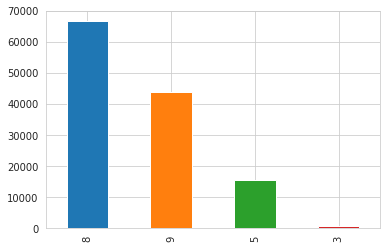

In [63]:
df['AddressAccuracy'].value_counts().plot.bar()

In [64]:
df['AddressAccuracy'].value_counts(normalize=True)

8    0.525249
9    0.345231
5    0.122777
3    0.006743
Name: AddressAccuracy, dtype: float64

Assuming "AddressAccuracy" of 8 and 9 are meaning high accuracy then 86% of the data has good accuracy. If we add in AddressAccuray=5 then the percentage is even higher at 98%.

In the EDA and the first round of modeling, I will keep all of the locations but I will keep in mind that there are some inaccurate location information. 

Meanwhile, we have latitude and logitude information, which are more convinient to use and more accurate, therefore I will drop these address information from the training set. 

<span style="color:red">Thoughts:</span> 
Just think a bit ahead, when using the location informaiton in the modeling, it might be helpful to grid seperate the area into small neighborhoods. Block information might be useful in that case? But I think I will be fine to do that using lon/lat values as well.

In [65]:
drop_cols(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'])

In [66]:
df.head(1)

Date  Latitude  Longitude  NumMosquitos                 Species  Trap  \
0 2007-05-29  41.95469 -87.800991           1.0  CULEX PIPIENS/RESTUANS  T002   

   WnvPresent  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  SnowFall  \
0         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0       0.0   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0          0.0        29.39     30.11          5.8       18.0       6.5   

    WnvPresent_str  
0  Wnv not present

In [67]:
#df_eda = df.loc[df['WnvPresent_str'] != 'nan', ['Date','Latitude', 'Longitude','WnvPresent', 'NumMosquitos', 'Species', 'Trap', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed','WnvPresent_str']]


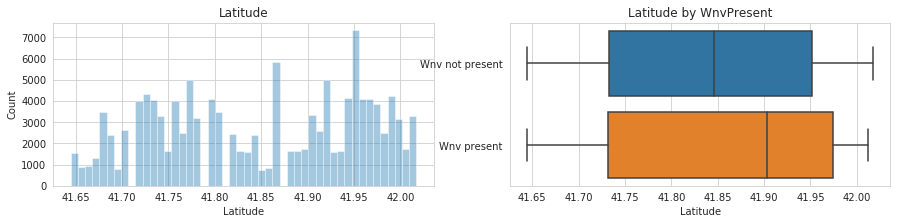

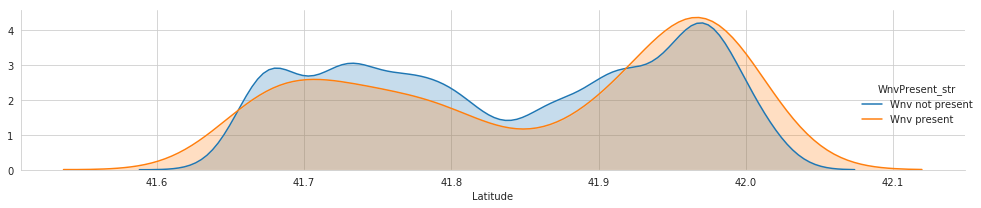

In [68]:
plot_var(df, 'Latitude', 'Latitude', continuous=True)

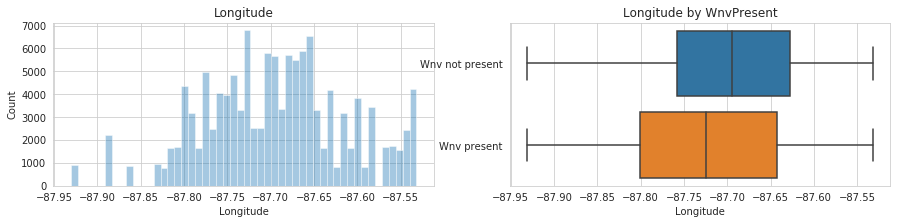

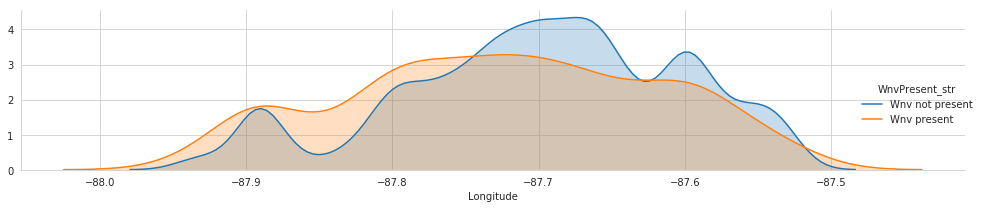

In [69]:
plot_var(df, 'Longitude', 'Longitude', continuous=True)

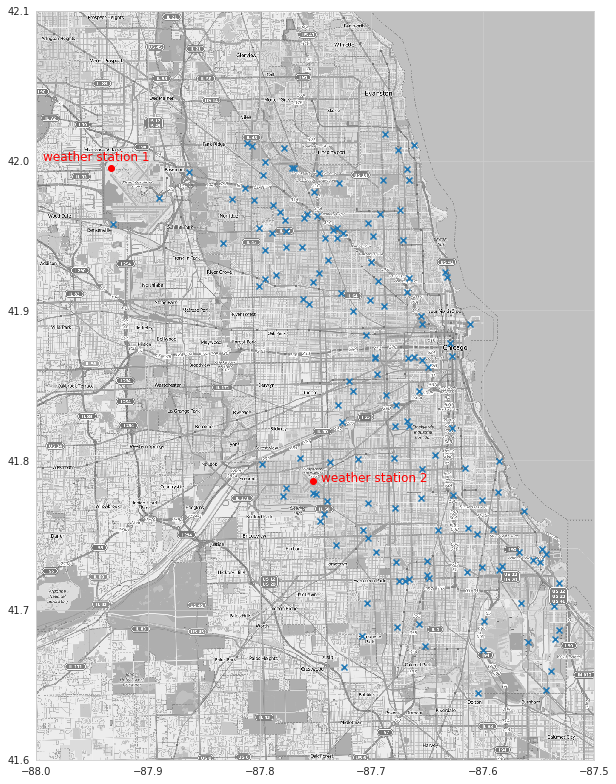

In [70]:
import matplotlib.tri as tri

# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("all/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

mapimg = './chicago.png'
#traps = pd.read_csv('../input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = df[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
                
# weather station
plt.scatter( [-87.933, -87.752], [41.995, 41.786], marker = 'o', color='red')
plt.text(-87.994, 42, 'weather station 1', fontsize=12, color = 'red')
plt.text(-87.745, 41.786, 'weather station 2', fontsize=12, color = 'red')

# Add this when copying to a script on Kaggle:
plt.savefig('./output/heatmap.png', dpi=300)

## Calculating the distances from traps to the seashore:

In [71]:
df.head(1)

Date  Latitude  Longitude  NumMosquitos                 Species  Trap  \
0 2007-05-29  41.95469 -87.800991           1.0  CULEX PIPIENS/RESTUANS  T002   

   WnvPresent  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  SnowFall  \
0         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0       0.0   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0          0.0        29.39     30.11          5.8       18.0       6.5   

    WnvPresent_str  
0  Wnv not present

In [72]:
import math

point1 = (-37.8206195, 144.9837765) # Lat/Long (lambda/phi)
point2 = (-37.8193712, 144.9837765) # Lat/Long (lambda/phi)

r = 6371000 # meters
phi_0 = point1[1]
cos_phi_0 = math.cos(math.radians(phi_0))

def to_xy(point, r, cos_phi_0):
    lam = point[0]
    phi = point[1]
    return (r * math.radians(lam) * cos_phi_0, r * math.radians(phi))

point1_xy = to_xy(point1, r, cos_phi_0)
point2_xy = to_xy(point2, r, cos_phi_0)


In [73]:
point1_xy

(3444228.8365710177, 16121460.392568598)

In [74]:
import geopy.distance
p1 = (42.1, -87.7)
p2 = (41.7, -87.5)

r = 6371000 *0.000621371 # miles

def distance_to_line(p1, p2, x, y):
    lam = p1[0]
    phi = p1[1]
    cos_phi_0 = math.cos(math.radians(phi))
    p1_x = r * math.radians(lam) * cos_phi_0
    p1_y = r * math.radians(phi)
    
    lam = p2[0]
    phi = p2[1]
    cos_phi_0 = math.cos(math.radians(phi))
    p2_x = r * math.radians(lam) * cos_phi_0
    p2_y = r * math.radians(phi)
    
    
    lam = x
    phi = y
    cos_phi_0 = math.cos(math.radians(phi))
    p3_x = r * math.radians(lam) * cos_phi_0
    p3_y = r * math.radians(phi)
      
    x_diff = p1_x - p2_x
    y_diff = p1_y - p2_y
    num = abs(y_diff*p3_x - x_diff*p3_y + p2_x*p1_y - p2_y*p1_x)
    den = math.sqrt(y_diff**2 + x_diff**2)
    return num / den

#print geopy.distance.vincenty(coords_1, coords_2).km

In [75]:
df.head()

Date   Latitude  Longitude  NumMosquitos                 Species  \
0 2007-05-29  41.954690 -87.800991           1.0  CULEX PIPIENS/RESTUANS   
1 2007-05-29  41.954690 -87.800991           1.0          CULEX RESTUANS   
2 2007-05-29  41.994991 -87.769279           1.0          CULEX RESTUANS   
3 2007-05-29  41.974089 -87.824812           1.0  CULEX PIPIENS/RESTUANS   
4 2007-05-29  41.974089 -87.824812           4.0          CULEX RESTUANS   

   Trap  WnvPresent  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  \
0  T002         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
1  T002         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
2  T007         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
3  T015         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
4  T015         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   

   SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
0       0.0          0.0        29.39     30.11          5.8       18.0   
1       0.0          0.0        29.39     30.11          5.8       18.0   
2       0.0          0.0        29.39     30.11          5.8       18.0   
3       0.0          0.0        29.39     30.11          5.8       18.0   
4       0.0          0.0        29.39     30.11          5.8       18.0   

   AvgSpeed   WnvPresent_str  
0       6.5  Wnv not present  
1       6.5  Wnv not present  
2       6.5  Wnv not present  
3       6.5  Wnv not present  
4       6.5  Wnv not present

In [76]:
#distance_to_line(p1, p2, 41.95469, -87.800991)
df['trap_dist'] = df.apply(lambda row: distance_to_line(p1, p2, row['Latitude'], row['Longitude']), axis=1)
df['trap_dist'] = df['trap_dist'] - df['trap_dist'].mean()

In [77]:
"""
from vectors import *
  
# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest 
# distance from pnt to the line and the coordinates of the 
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line. 
# Malcolm Kesson 16 Dec 2012
  
def pnt2line(pnt, start, end):
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)    
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distance(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)
"""

"\nfrom vectors import *\n  \n# Given a line with coordinates 'start' and 'end' and the\n# coordinates of a point 'pnt' the proc returns the shortest \n# distance from pnt to the line and the coordinates of the \n# nearest point on the line.\n#\n# 1  Convert the line segment to a vector ('line_vec').\n# 2  Create a vector connecting start to pnt ('pnt_vec').\n# 3  Find the length of the line vector ('line_len').\n# 4  Convert line_vec to a unit vector ('line_unitvec').\n# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').\n# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').\n# 7  Ensure t is in the range 0 to 1.\n# 8  Use t to get the nearest location on the line to the end\n#    of vector pnt_vec_scaled ('nearest').\n# 9  Calculate the distance from nearest to pnt_vec_scaled.\n# 10 Translate nearest back to the start/end line. \n# Malcolm Kesson 16 Dec 2012\n  \ndef pnt2line(pnt, start, end):\n    line_vec = vector(start, end)\n    pnt_vec = vector(start, pnt)\n    line_l

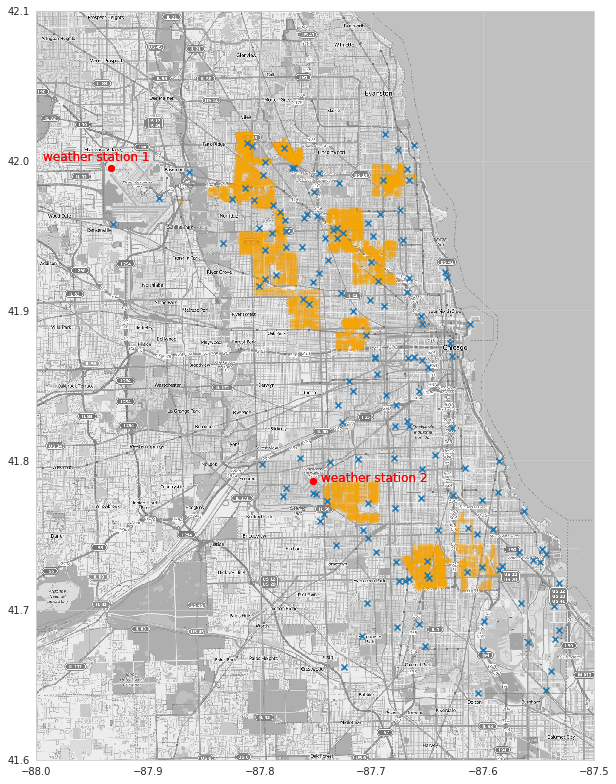

In [78]:
import matplotlib.tri as tri

# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("all/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")

#mapimg = './chicago.png'

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

# spraying locations
locations_spray = df_spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations_spray[:,0], locations_spray[:,1], marker='.', alpha = 0.1, color='orange')

# traps
locations = df[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
                
# weather station
plt.scatter( [-87.933, -87.752], [41.995, 41.786], marker = 'o', color='red')
plt.text(-87.994, 42, 'weather station 1', fontsize=12, color = 'red')
plt.text(-87.745, 41.786, 'weather station 2', fontsize=12, color = 'red')
                
plt.scatter( [-87.933, -87.752], [41.995, 41.786], marker = 'o', color='red')
plt.text(-87.994, 42, 'weather station 1', fontsize=12, color = 'red')
plt.text(-87.745, 41.786, 'weather station 2', fontsize=12, color = 'red')

# Add this when copying to a script on Kaggle:
plt.savefig('./output/spray_traps.png', dpi=300)

In addition to mosquito population size and weather variables, there is likely to be an effect based on a trap’s geographic location. Next, I will visually examine the relationship between geography and West Nile presence, as I mentioned earlier in this notebook

First I created a map of Wnv incidents as a density plot. Here, the density is derived from the overall **positive count** for each trap.

In [79]:
df_pos = df[df['WnvPresent'] == 1]

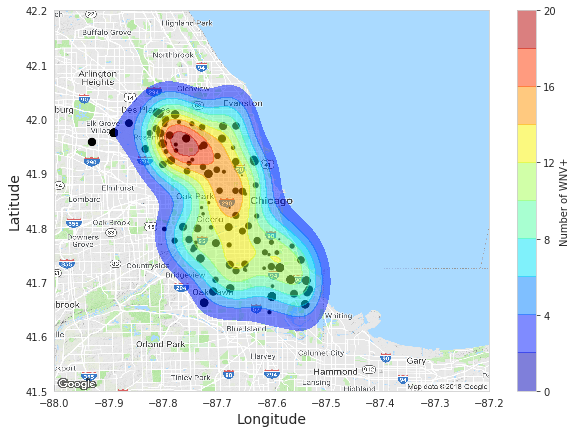

In [80]:
import matplotlib.image as mpimg

chicago_img=mpimg.imread(os.path.join('./','chicago.png'))
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.

# scatter
ax = df_pos.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(10,7), s=df_pos['NumMosquitos'], c='black', alpha=1) #cmap=plt.get_cmap("jet"),colorbar=True, alpha=0.4)
ax.grid(False)

#locations = df[['Longitude', 'Latitude']].drop_duplicates().values
#plt.scatter(locations[:,0], locations[:,1], marker='x')

# contour
ax = sns.kdeplot(locations[:,0], locations[:,1], shade=True, shade_lowest=False, cbar=True, alpha=0.5, cmap='jet',cbar_kws={'label': 'Number of WNV+'})


#longitude_top_left,longitude_top_right,latitude_bottom_left,latitude_top_left
plt.imshow(chicago_img, extent=[-88., -87.2, 41.5, 42.2], alpha=1)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

numbers = df_pos['NumMosquitos']
tick_values = np.linspace(numbers.min(), numbers.max(), 11)


#plt.legend(fontsize=16)
plt.savefig("./output/heatmap_color.png", dpi=300)
plt.show()



It’s clear from the density map that there are hotspot traps where Wnv is more common than others, and this appears to influence nearby traps.

In [81]:
#import gmaps
#fig = gmaps.figure()
#fig.add_layer(gmaps.heatmap_layer(locations))
#fig

Now that I have a good 2-dimensional view of the occurence of Wnv, I next wanted to get a sense of how this pattern of Wnv changed over time in relation to the geography. I did this by creating a series of png files for each timestamp. I chose to remove the background map of Chicago to get a clearer visual of positive vs negative cases. I will then convert this png files to a gif.

In [82]:
# I will use a scalar to describe the length of time since the first trap. 

from datetime import datetime

df_pos['time_length'] = pd.to_datetime(df_pos.Date)

dttoday = datetime.now().strftime('%Y-%m-%d')
df_pos['time_length'] = df_pos.time_length.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df_pos.time_length.shape

(551,)

In [83]:
measure_num = df.groupby('Date')['NumMosquitos'].sum()
#measure_num.values

<span style="color:red">Thoughts:</span> 

Here, I am asking the question: 

Is there a long-term change of the number of mosquitos? any seasonality?



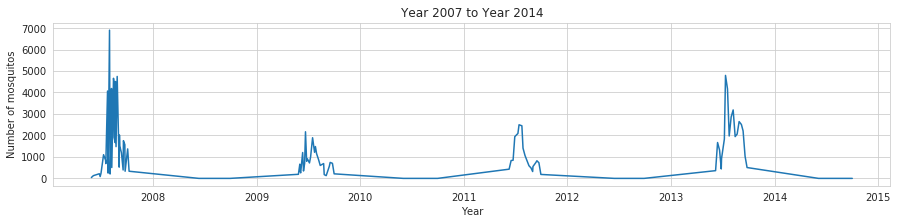

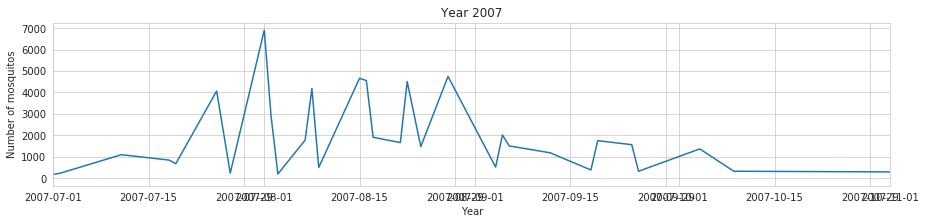

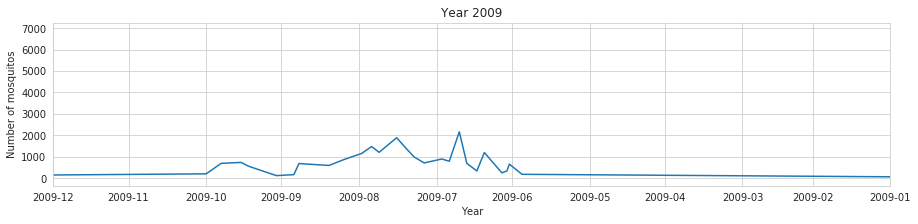

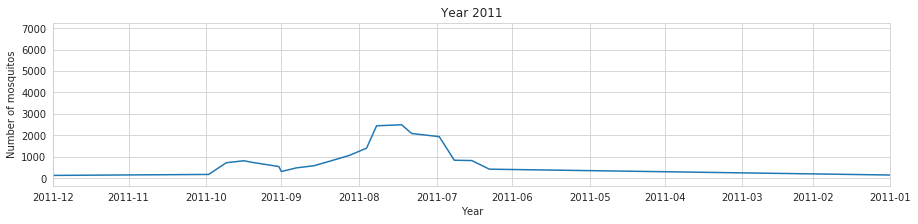

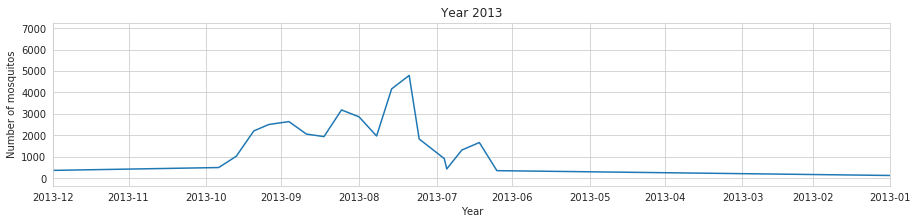

In [84]:
# plot 4:
fig, ax = plt.subplots( figsize=(15,3))
ax = plt.plot(measure_num.index, measure_num.values)
plt.title('Year 2007 to Year 2014')
plt.xlabel('Year')
plt.ylabel('Number of mosquitos')
plt.show()


# year 2007
fig, ax = plt.subplots( figsize=(15,3))
ax = plt.plot(measure_num.index, measure_num.values)
plt.title('Year 2007')
plt.xlabel('Year')
plt.ylabel('Number of mosquitos')
plt.xlim(right = '2007-11', left = '2007-07')
plt.show()


# year 2009
fig, ax = plt.subplots( figsize=(15,3))
ax = plt.plot(measure_num.index, measure_num.values)
plt.title('Year 2009')
plt.xlabel('Year')
plt.ylabel('Number of mosquitos')
plt.xlim(right = '2009-1', left = '2009-12')
plt.show()


# year 2011
fig, ax = plt.subplots( figsize=(15,3))
ax = plt.plot(measure_num.index, measure_num.values)
plt.title('Year 2011')
plt.xlabel('Year')
plt.ylabel('Number of mosquitos')
plt.xlim(right = '2011-1', left = '2011-12')
plt.show()


# year 2013
fig, ax = plt.subplots( figsize=(15,3))
ax = plt.plot(measure_num.index, measure_num.values)
plt.title('Year 2013')
plt.xlabel('Year')
plt.ylabel('Number of mosquitos')
plt.xlim(right = '2013-1', left = '2013-12')
plt.show()



<span style="color:red">Thoughts:</span> 

Here I will perform a time series analsis, 2 purpose:

- whethere there is a large-scale, long-term change of the number of the mosquitos that can be well-modeled with time series models. 

- I earlier thought that I could use ML regression models to predict "NumMosquitos", but not I think I can also compare with the predictions from time series analysis. 

- for the Time series analysis, here I am using Facebook's Prophet package. Based on my previous relevant project experience, I found it to be really "user-friendly", that is, easy to tune parameters. But the results are not necessarily better than ARIMA model. 

If I decide to use time series to predict the number of mosquitos in testing dataset then I will further compare different time series models. 

Also, it would be interesting to investigate the time series of temperature and precipitation as well. Especially a comparision of the trend of temperature with the number of mosquitos. 

In [85]:
num_ts = pd.DataFrame({'ds':measure_num.index, 'y':measure_num.values})

from fbprophet import Prophet
num_model = Prophet(interval_width=0.95)
num_model.fit(num_ts)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [86]:
num_forecast = num_model.make_future_dataframe(periods=25, freq='D')
num_forecast = num_model.predict(num_forecast)


Text(0.5, 1.0, 'Number of mosquitos')

<Figure size 1296x432 with 0 Axes>

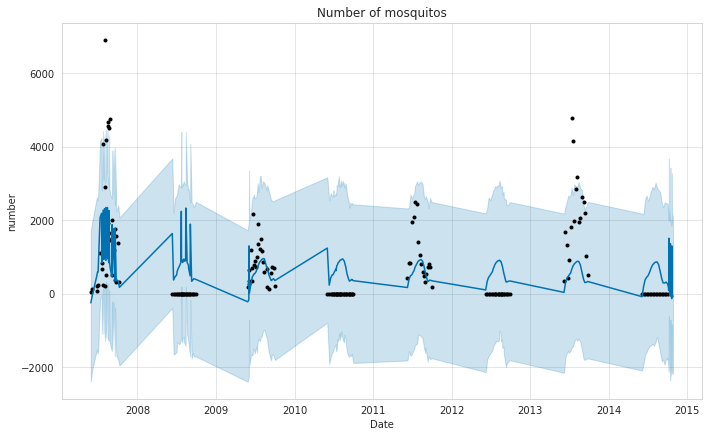

In [87]:
plt.figure(figsize=(18, 6))
num_model.plot(num_forecast, xlabel = 'Date', ylabel = 'number')
plt.title('Number of mosquitos')

In [88]:
num_forecast.head(2)

ds       trend  trend_lower  trend_upper   yhat_lower   yhat_upper  \
0 2007-05-29  431.632544   431.632544   431.632544 -2379.136407  1727.616377   
1 2007-06-05  431.310568   431.310568   431.310568 -2048.830894  1971.270400   

   additive_terms  additive_terms_lower  additive_terms_upper  \
0     -675.336787           -675.336787           -675.336787   
1     -470.186321           -470.186321           -470.186321   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   

   multiplicative_terms_upper      weekly  weekly_lower  weekly_upper  \
0                         0.0 -252.098137   -252.098137   -252.098137   
1                         0.0 -252.098137   -252.098137   -252.098137   

       yearly  yearly_lower  yearly_upper        yhat  
0 -423.238650   -423.238650   -423.238650 -243.704244  
1 -218.088184   -218.088184   -218.088184  -38.875753

Trends and Patterns:

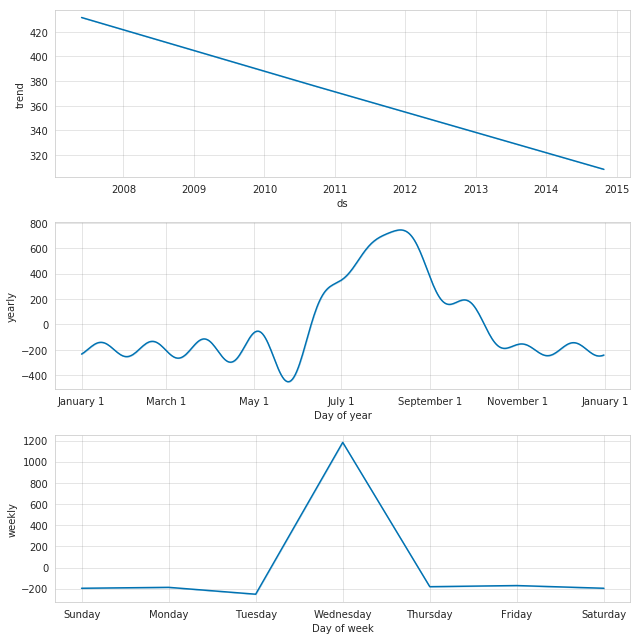

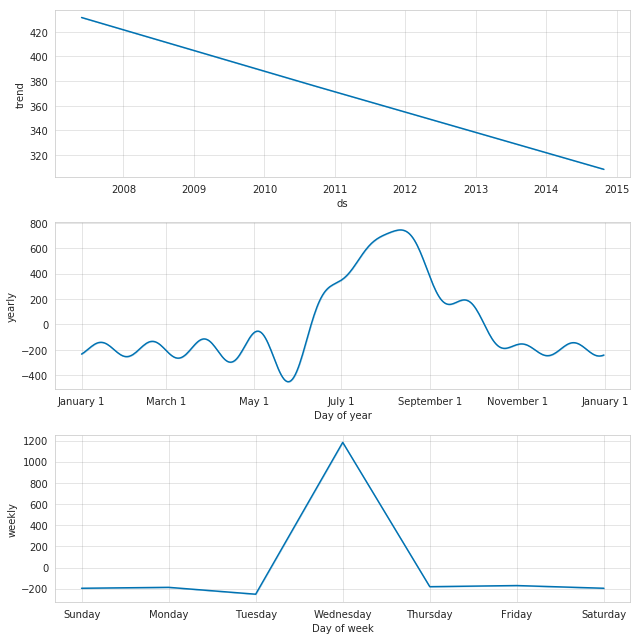

In [89]:
num_model.plot_components(num_forecast)

What I see from the above figures are:
1. The number of mosquitos is decreasing for years from 2007 to 2014

2. The number of mosquitos peaks around August yearly. 

3. Most of the measurements are done on Wednesday. 

However, I do not have an idea about whether the predictions are accurate, and better than others (e.g., ARIMA time series model, other ML regression models)

In [90]:
#(Note: there are some technical problems for the following code. I will come back to this later.)
""" 
timepoints = df_pos.Date.unique()
for idx, timepoint in enumerate(timepoints):
    df = df_pos[df_pos['Date'] == timepoint]
    df.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(10,7),s=df['NumMosquitos'], c='red', colorbar=False, alpha=0.4)

#ax = sns.kdeplot(locations[:,0], locations[:,1], shade=True, shade_lowest=False, cbar=True, alpha=0.5, cmap='jet',cbar_kws={'label': 'Number of WNV+'})

    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    plt.savefig("./output/timestamp/heatmap_color_"+str(idx)+".png", dpi=300)
"""

' \ntimepoints = df_pos.Date.unique()\nfor idx, timepoint in enumerate(timepoints):\n    df = df_pos[df_pos[\'Date\'] == timepoint]\n    df.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(10,7),s=df[\'NumMosquitos\'], c=\'red\', colorbar=False, alpha=0.4)\n\n#ax = sns.kdeplot(locations[:,0], locations[:,1], shade=True, shade_lowest=False, cbar=True, alpha=0.5, cmap=\'jet\',cbar_kws={\'label\': \'Number of WNV+\'})\n\n    plt.xlabel("Longitude", fontsize=14)\n    plt.ylabel("Latitude", fontsize=14)\n    plt.savefig("./output/timestamp/heatmap_color_"+str(idx)+".png", dpi=300)\n'

In [91]:
""" 
import imageio
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./output/heatmap.gif', images)
"""

" \nimport imageio\nimages = []\n\nfor filename in filenames:\n    images.append(imageio.imread(filename))\nimageio.mimsave('./output/heatmap.gif', images)\n"

In [92]:
df['Week_Number'] = df['Date'].dt.week

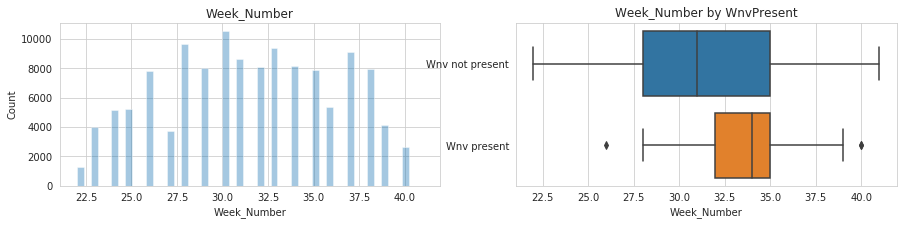

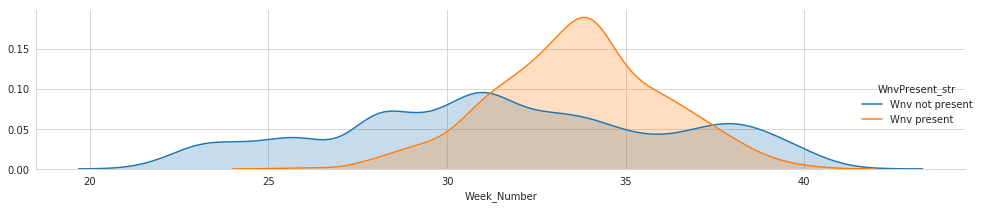

In [93]:
plot_var(df, 'Week_Number','Week_Number',continuous=True)

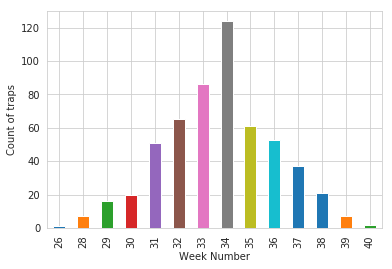

In [94]:
df[df['WnvPresent'] == 1]['Week_Number'].value_counts().sort_index().plot.bar()
plt.xlabel('Week Number')
plt.ylabel('Count of traps')
plt.show()

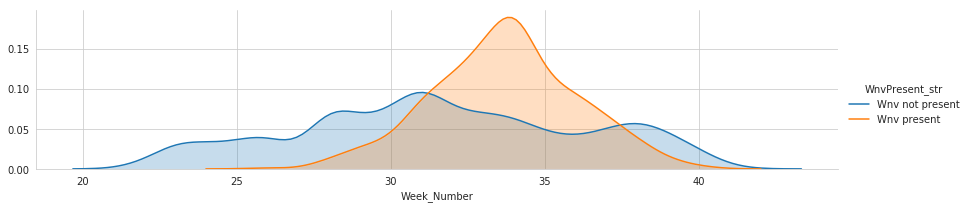

In [95]:
facet = sns.FacetGrid(df, hue = 'WnvPresent_str', size=3, aspect=4)
facet.map(sns.kdeplot, 'Week_Number', shade=True)
facet.add_legend()  

In [96]:
df.head(1)

Date  Latitude  Longitude  NumMosquitos                 Species  Trap  \
0 2007-05-29  41.95469 -87.800991           1.0  CULEX PIPIENS/RESTUANS  T002   

   WnvPresent  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  SnowFall  \
0         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0       0.0   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0          0.0        29.39     30.11          5.8       18.0       6.5   

    WnvPresent_str  trap_dist  Week_Number  
0  Wnv not present  -0.272072           22

### "Trap"

In [97]:
df.Trap.describe()

count     126799
unique       149
top         T900
freq        2218
Name: Trap, dtype: object

There are 149 mosquito traps.

In [98]:
df.groupby('Trap')['NumMosquitos'].agg(['sum','mean','count']).sort_values('mean', ascending=False).head(10)

sum       mean  count
Trap                           
T115  21668.0  39.977860    542
T103   2988.0  36.000000     83
T138   9936.0  31.643312    314
T128   3315.0  20.718750    160
T900  15386.0  20.514667    750
T002   3710.0  20.054054    185
T225   2014.0  19.553398    103
T008   2668.0  19.194245    139
T215    852.0  18.933333     45
T158   2575.0  17.517007    147

Overtime, the total number of mosquitos, the mean numer, and the number of observations are shown above.

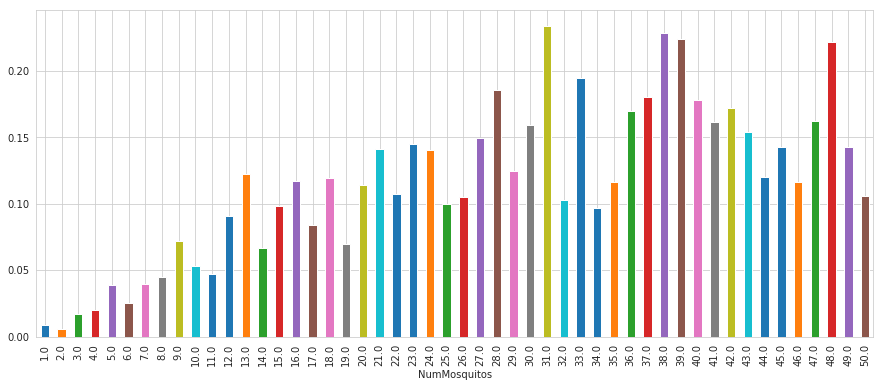

In [99]:
fig, ax1 = plt.subplots(1, 1,  figsize=(15,6))
df.groupby('NumMosquitos')['WnvPresent'].mean().plot.bar()

<span style="color:red">Thoughts:</span> 

Trap locations are clearly relevant to Wnv presence. However, how to include this feature? Well, the trap info can be extracted from 2 features:

- 1. The latitude and longitude of the traps (numerical feature)

This will provide geographic information at very high precision. It would requires a decision tree or other model that allows for breaking up or clustering the locations in some non-linear way.

- 2. The trap ids/names (categorical feature)

It's also possible to manually group the traps into clusters and include the cluster as a modeling parameter. The reasoning for this is that suspect that the true risk based on geography has a much lower actual precision than our ability to define latitude or longitude.

I would like to try Kmeans.

### Species:

In [100]:
df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    20111
CULEX RESTUANS            17410
CULEX PIPIENS             17220
CULEX TERRITANS           14573
CULEX SALINARIUS          14441
CULEX TARSALIS            14353
CULEX ERRATICUS           14346
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

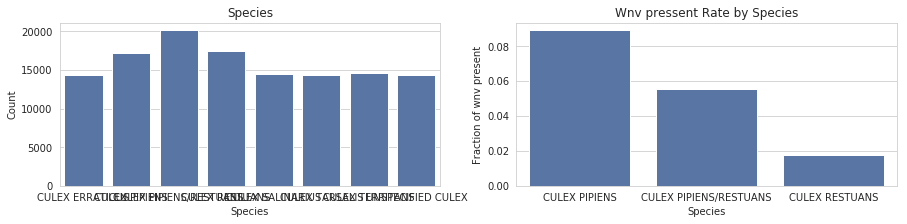

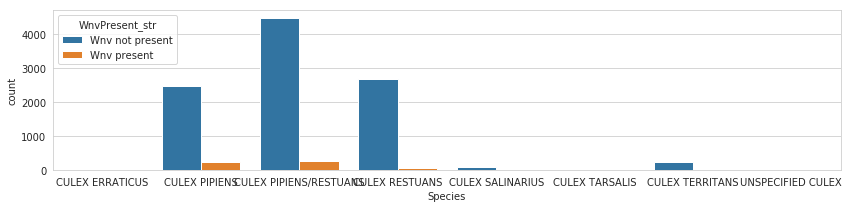

In [101]:
plot_var(df, 'Species','Species',continuous=False)

In [102]:
df.groupby('Species')['WnvPresent'].value_counts()

Species                 WnvPresent
CULEX ERRATICUS         0.0              1
CULEX PIPIENS           0.0           2459
                        1.0            240
CULEX PIPIENS/RESTUANS  0.0           4490
                        1.0            262
CULEX RESTUANS          0.0           2691
                        1.0             49
CULEX SALINARIUS        0.0             86
CULEX TARSALIS          0.0              6
CULEX TERRITANS         0.0            222
Name: WnvPresent, dtype: int64

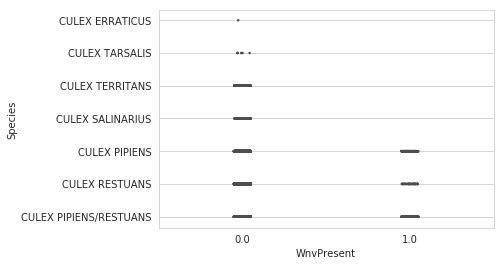

In [103]:
ax = sns.stripplot(x="WnvPresent", y="Species", data=df, jitter=0.05, size = 5, marker='.', color=".3", orient='v')
ax.set_xticks([0,1])
plt.show()

wnv was found in only 3 types of species: "CULEX PIPIENS" (240), "CULEX RESTUANS" (49), and "CULEX PIPIENS/RESTUANS" (262)


Mosquito species including Culex Pipiens yielded 3–4x higher rates of WNV presence than Culex Restuan, and other mosquitos in the sample demonstrated no WNV presence at all. While a quick search reveals that the other Culex types were also carriers, the virus is most famously associated, at least in the Chicago area, with Culex Pipiens and Culex Restuan.


I made the assumption that the other types of mosquitos were unlikely carriers. 


In order to encode these categorical features. I will group non-relevant species ("culex erraticus", "culex tarsalis", "culex territans", "culex salinarius") together to save some feature space. 

To deal with this categorical feature, I will encode it into numerical format.

As for the encoding methods, depending on my modeling algorithm, I can use one-hot encoding or label encoding. 

- One-hot encoding:

I will get 4 columns and the presence of a class will be represented in binary like format. But, here the four classes are separated out to four different columns(features). The Algorithm is only worried about their presence/absence without making any assumptions of their relationship. 

- label encoding. 

Label Encoding gives numerical aliases to different classes. The problem with this approach is that there is no relation between thee four classes yet our Algorithm might consider them to be ordered (that is there is some relation between them).

Since I only have 4 classes here: "non-relevant", "CULEX PIPIENS", "CULEX RESTUANS", and "CULEX PIPIENS/RESTUANS", so one hot-encoding should work fine and I won't need to worry about a large feature space introduced by one-hot encoding.

#### Label Encoding

In [104]:
df['Species_label'] = df['Species']

In [105]:
df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    20111
CULEX RESTUANS            17410
CULEX PIPIENS             17220
CULEX TERRITANS           14573
CULEX SALINARIUS          14441
CULEX TARSALIS            14353
CULEX ERRATICUS           14346
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

In [106]:
df['Species_label'].replace(['CULEX TERRITANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX ERRATICUS', 'UNSPECIFIED CULEX'], 'OTHERS', inplace=True)

In [107]:
df["Species_label"] = df["Species_label"].astype('category')
df["Species_label"] = df["Species_label"].cat.codes


In [108]:
df.head()

Date   Latitude  Longitude  NumMosquitos                 Species  \
0 2007-05-29  41.954690 -87.800991           1.0  CULEX PIPIENS/RESTUANS   
1 2007-05-29  41.954690 -87.800991           1.0          CULEX RESTUANS   
2 2007-05-29  41.994991 -87.769279           1.0          CULEX RESTUANS   
3 2007-05-29  41.974089 -87.824812           1.0  CULEX PIPIENS/RESTUANS   
4 2007-05-29  41.974089 -87.824812           4.0          CULEX RESTUANS   

   Trap  WnvPresent  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Depth  \
0  T002         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
1  T002         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
2  T007         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
3  T015         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   
4  T015         0.0  74.0    10.0      58.0     65.0   0.0   9.0    0.0   

   SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
0       0.0          0.0        29.39     30.11          5.8       18.0   
1       0.0          0.0        29.39     30.11          5.8       18.0   
2       0.0          0.0        29.39     30.11          5.8       18.0   
3       0.0          0.0        29.39     30.11          5.8       18.0   
4       0.0          0.0        29.39     30.11          5.8       18.0   

   AvgSpeed   WnvPresent_str  trap_dist  Week_Number  Species_label  
0       6.5  Wnv not present  -0.272072           22              1  
1       6.5  Wnv not present  -0.272072           22              2  
2       6.5  Wnv not present  -0.025062           22              2  
3       6.5  Wnv not present  -0.346565           22              1  
4       6.5  Wnv not present  -0.346565           22              2

### Tavg


In [109]:
df.Tavg.describe()

count    126799.000000
mean         71.581503
std           6.527692
min          50.000000
25%          67.000000
50%          72.000000
75%          77.000000
max          84.000000
Name: Tavg, dtype: float64

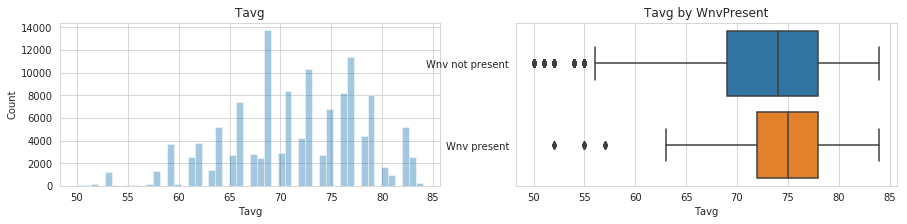

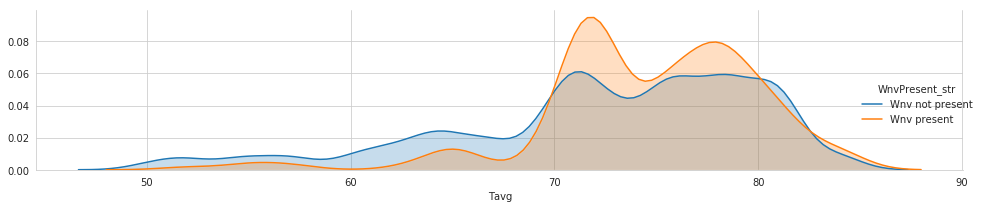

In [110]:
plot_var(df, 'Tavg', 'Tavg', continuous=True)

Text(0, 0.5, 'Number of mosquitoes')

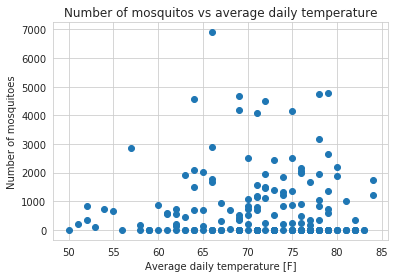

In [111]:
plt.scatter(df.groupby('Date')['Tavg'].mean().values, df.groupby(['Date'])['NumMosquitos'].agg(['sum']).sort_values('Date', ascending=False).values)

plt.title("Number of mosquitos vs average daily temperature")
plt.xlabel("Average daily temperature [F]")
plt.ylabel("Number of mosquitoes")

### PrecipTotal

In [112]:
df['PrecipTotal'].describe()

count    126799.000000
mean          0.165740
std           0.447254
min           0.000000
25%           0.000000
50%           0.000000
75%           0.070000
max           3.970000
Name: PrecipTotal, dtype: float64

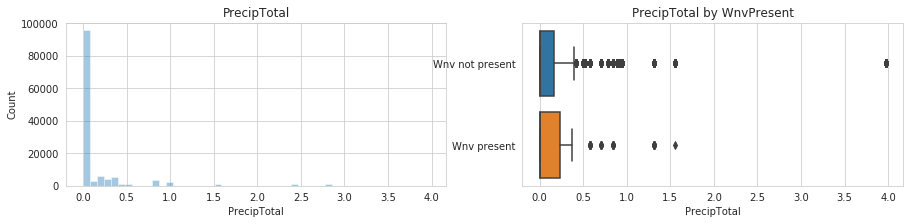

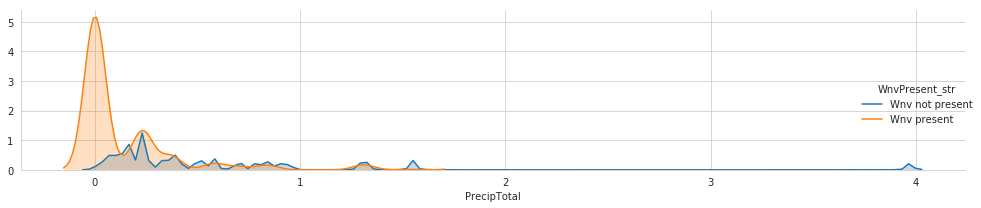

In [113]:
plot_var(df, 'PrecipTotal', 'PrecipTotal', continuous=True)

#### Outliers
outliers can be exactly what we want to learn about, e.g., anomaly detection.

In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization.

Below, I use the modified Z-score method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

In [114]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [115]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)
      
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [116]:
df.groupby('WnvPresent')['PrecipTotal'].describe()

count      mean       std  min  25%  50%   75%   max
WnvPresent                                                       
0.0         9955.0  0.182988  0.481252  0.0  0.0  0.0  0.16  3.97
1.0          551.0  0.137459  0.266193  0.0  0.0  0.0  0.23  1.55

Any values > 75% percentile (0.16 for "WnvPresent=0", 0.23 for "WnvPresent=1") are defined as outliers.



In [117]:
df.loc[(df.PrecipTotal > 0.16) & (df['WnvPresent'] == 0)].shape[0]/df['WnvPresent'].value_counts(normalize=False, dropna=False)[0]

0.24138623807132095

In [118]:
df.loc[(df.PrecipTotal > 0.23) & (df['WnvPresent'] == 1)].shape[0]/df['WnvPresent'].value_counts(normalize=False, dropna=False)[1]

0.19056261343012704

The percentage of outliers is roughly the same for the samples with/without wnv, ~20%-24%. A bit too much to be dropped. I will keep these outliers for now.

In [119]:
df = df[df['PrecipTotal'] < 3.5]

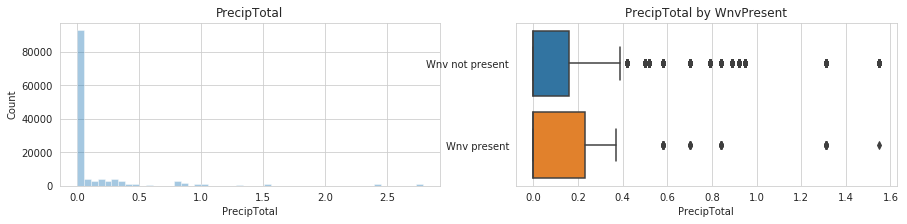

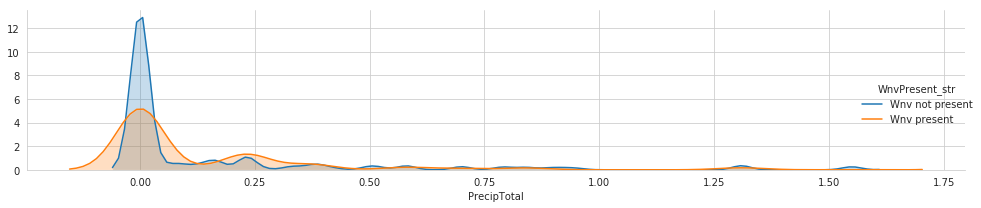

In [120]:
plot_var(df, 'PrecipTotal', 'PrecipTotal', continuous=True)

### Other weather features
DewPoint          
WetBulb           
Depth             
SnowFall          
StnPressure       
SeaLevel          
AvgSpeed

In [121]:
tmp = ['DewPoint', 'WetBulb', 'Depth', 'SnowFall', 'StnPressure', 'SeaLevel', 'AvgSpeed']

In [122]:
df[tmp].describe()

DewPoint        WetBulb     Depth  SnowFall    StnPressure  \
count  126706.000000  126706.000000  126706.0  126706.0  126706.000000   
mean       57.481011      63.108598       0.0       0.0      29.270865   
std         7.243834       5.880658       0.0       0.0       0.119011   
min        39.000000      46.000000       0.0       0.0      28.890000   
25%        52.000000      59.000000       0.0       0.0      29.180000   
50%        57.000000      64.000000       0.0       0.0      29.270000   
75%        63.000000      68.000000       0.0       0.0      29.350000   
max        73.000000      76.000000       0.0       0.0      29.590000   

            SeaLevel       AvgSpeed  
count  126706.000000  126706.000000  
mean       29.984205       7.947913  
std         0.121846       2.599730  
min        29.600000       1.900000  
25%        29.890000       6.100000  
50%        29.990000       7.800000  
75%        30.070000       9.700000  
max        30.330000      17.300000

In [123]:
drop_cols(['Depth', 'SnowFall'])

In [124]:
tmp = ['DewPoint', 'WetBulb','StnPressure', 'SeaLevel', 'AvgSpeed']

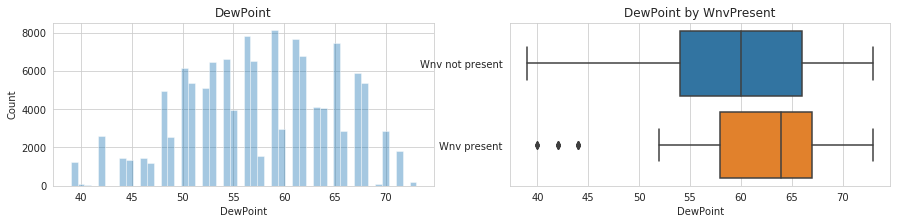

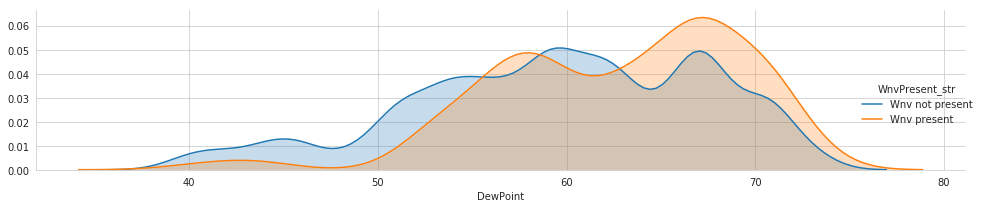

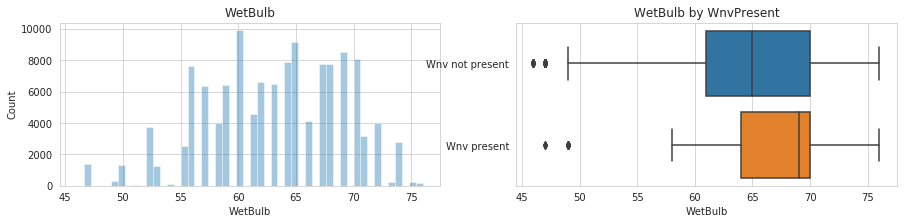

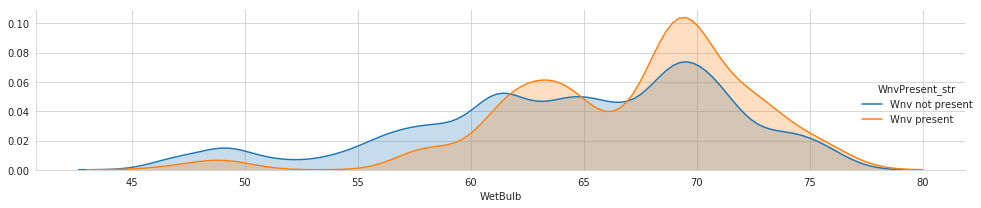

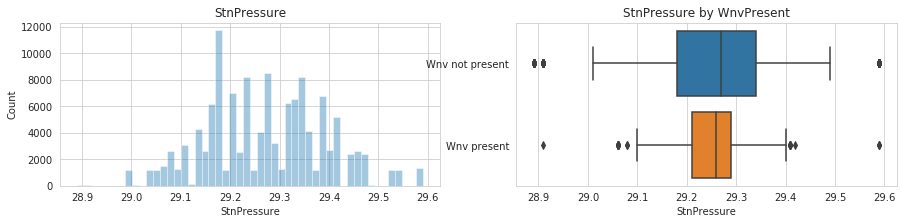

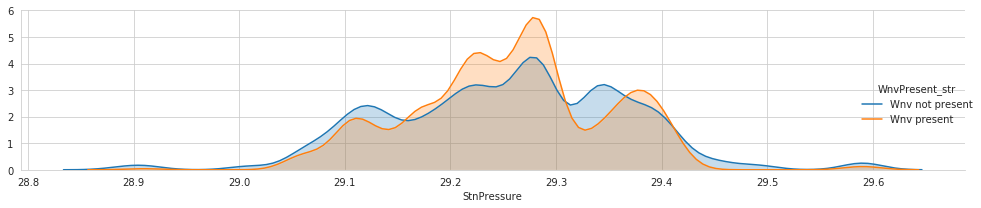

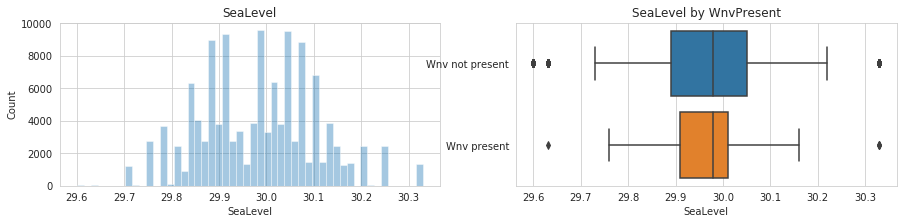

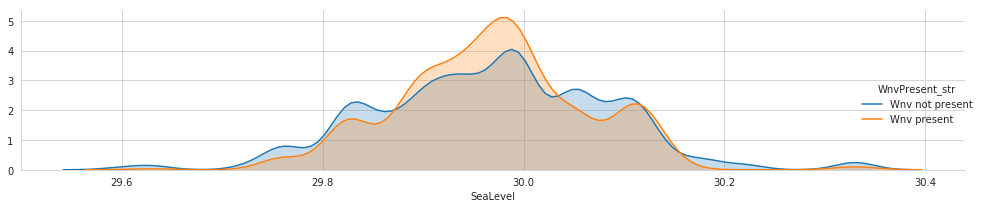

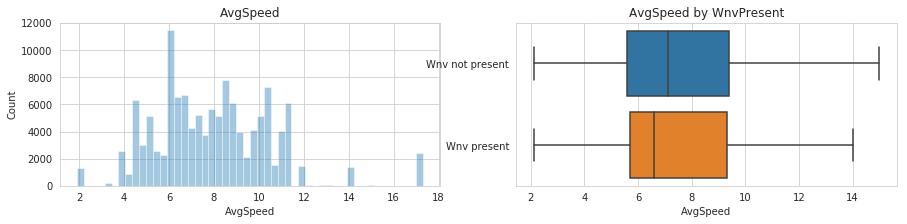

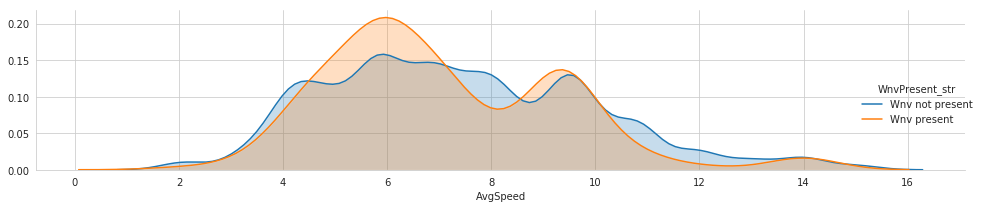

In [125]:
for item in tmp:
    plot_var(df, item, item, continuous=True)

Interestingly, I found that "Dewpoint" and "WetBulb" seem to distribute differently and have differnt median values for Wnvpresent/not present samples. 

I will further examine this with statistical tests. 

## 4. Feature Section II: Statistical Overview
<a id="corr"></a>

I have looked at the features individually. Now I will do some overall statistical tests for all the features on their distributions, correlations, etc.

## 4.1 Hypothesis testing on the two distributions of each feature
<a id="kstest"></a>

Here I can group the data to "Wnv present" & "Wnv not present", and then use hypothesis tests to compare the two distributions of each feature.

If the test statistic is small or the p-value is high (>0.05, 95% confidence level), we cannot reject the null hypothesis that the distributions of the two samples are the same and if p<0.05, then we can reject the null hyposis.

K-S Tests, Z Tests and chi-squared Tests:

- Numerical features: We can use K-S tests

- Features with only 0 or 1 values, we can use proportion Z tests to check whether the difference in mean values is statistically significant.

- For categorical features, we can use chi-squared Tests

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126706 entries, 0 to 126798
Data columns (total 23 columns):
Date              126706 non-null datetime64[ns]
Latitude          126706 non-null float64
Longitude         126706 non-null float64
NumMosquitos      10413 non-null float64
Species           126706 non-null object
Trap              126706 non-null object
WnvPresent        10413 non-null float64
Tavg              126706 non-null float64
Depart            126706 non-null float64
DewPoint          126706 non-null float64
WetBulb           126706 non-null float64
Heat              126706 non-null float64
Cool              126706 non-null float64
PrecipTotal       126706 non-null float64
StnPressure       126706 non-null float64
SeaLevel          126706 non-null float64
ResultSpeed       126706 non-null float64
ResultDir         126706 non-null float64
AvgSpeed          126706 non-null float64
WnvPresent_str    10413 non-null object
trap_dist         126706 non-null float64
Week_N

In [127]:
list_float = df.select_dtypes(exclude=['object']).columns
list_object = ['Species', 'Trap']

In [128]:
def run_KS_test(feature):
    dist1 = df.loc[df.WnvPresent == 0,feature]
    dist2 = df.loc[df.WnvPresent == 1,feature]
    print(feature+':')
    print(ks_2samp(dist1,dist2),'\n')

In [129]:
from statsmodels.stats.proportion import proportions_ztest
def run_proportion_Z_test(feature):
    dist1 = df.loc[df.WnvPresent == 0, feature]
    dist2 = df.loc[df.WnvPresent == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature+':')
    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')

In [130]:
df['WnvPresent_str'].value_counts()

Wnv not present    9862
Wnv present         551
Name: WnvPresent_str, dtype: int64

In [131]:
from scipy.stats import chi2_contingency
def run_chi2_test(df, feature):

    dist1 = df.loc[df.WnvPresent_str == 'Wnv not present',feature].value_counts().sort_index().tolist()
    dist2 = df.loc[df.WnvPresent_str == 'Wnv present',feature].value_counts().sort_index().tolist()
    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])
    print(feature+':')
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')

In [132]:
for i in list_float:
    run_KS_test(i)

Date:
Ks_2sampResult(statistic=0.2762371175948599, pvalue=2.1604407103447409e-35) 

Latitude:
Ks_2sampResult(statistic=0.11647137024513599, pvalue=1.2156566028187674e-06) 

Longitude:
Ks_2sampResult(statistic=0.14119715964152857, pvalue=1.4634279924094116e-09) 

NumMosquitos:
Ks_2sampResult(statistic=0.45222822684442765, pvalue=3.8662413163829316e-94) 

WnvPresent:
Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Tavg:
Ks_2sampResult(statistic=0.21519822921102505, pvalue=1.2024172950409847e-21) 

Depart:
Ks_2sampResult(statistic=0.17083354649885296, pvalue=8.469608825779928e-14) 

DewPoint:
Ks_2sampResult(statistic=0.2047270481464537, pvalue=1.2444146328267336e-19) 

WetBulb:
Ks_2sampResult(statistic=0.21246210407801894, pvalue=4.132856706751747e-21) 

Heat:
Ks_2sampResult(statistic=0.130280815360873, pvalue=3.3371163649848604e-08) 

Cool:
Ks_2sampResult(statistic=0.21519822921102505, pvalue=1.2024172950409847e-21) 

PrecipTotal:
Ks_2sampResult(statistic=0.09121061207273806, pvalue=0.000308

Now, I know that statistically, all of these features have different distributions for Wnv present or not. 

## 4.2 Pearson correlation & Heatmap
<a id="pearson"></a>

In [133]:
list_float

Index(['Date', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'trap_dist', 'Week_Number', 'Species_label'],
      dtype='object')

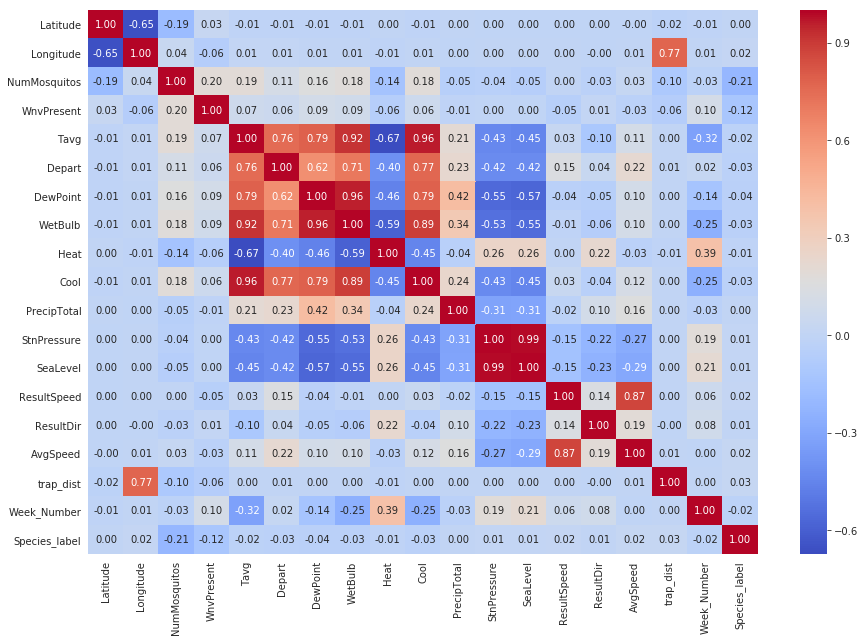

In [134]:
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
cm_df = sns.heatmap(df[list_float].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)


Note that, as I didn't aggressively remove the features (especially in the weather data), therefore there will be some correlated features here (collinearity) but it's ok. I can just remove those correlated features before modeling. 

- The linearly correlated features are:
"Tavg": "Depart" (0.76), "DewPoint" (0.79), "WetBulb"(0.92), "Cool" (0.96), "heat" (-0.67). 

"Sealevel": "Stnpressure" (0.99)
"AvgSpeed": "ResultSpeed" (0.87)

- More importantly, the features that are correlated with "NumMosquitos are:
"WnvPresent", "Tavg" ("WebBulb", "cool", "Dewpoint"), "Latitude"

- "WnvPresent", the final target variable, seems to be only strongly correlated with "NumMosquitos".

In [135]:
cor = df[list_float].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

Longitude      Latitude       -0.653203
NumMosquitos   Latitude       -0.185226
WnvPresent     NumMosquitos    0.196621
Tavg           NumMosquitos    0.191456
Depart         NumMosquitos    0.106113
               Tavg            0.756875
DewPoint       NumMosquitos    0.164105
               Tavg            0.790280
               Depart          0.621997
WetBulb        NumMosquitos    0.180945
               Tavg            0.917263
               Depart          0.707013
               DewPoint        0.960760
Heat           NumMosquitos   -0.136938
               Tavg           -0.671524
               Depart         -0.401215
               DewPoint       -0.459334
               WetBulb        -0.589911
Cool           NumMosquitos    0.184880
               Tavg            0.962980
               Depart          0.767798
               DewPoint        0.786984
               WetBulb         0.892784
               Heat           -0.446915
PrecipTotal    Tavg            0.208435


In [136]:
# Drop the linear correlated features
list_linear = [ "Depart", "DewPoint", "WetBulb", "Cool" , "Heat", "StnPressure", "ResultSpeed"]

In [137]:
drop_cols(list_linear)

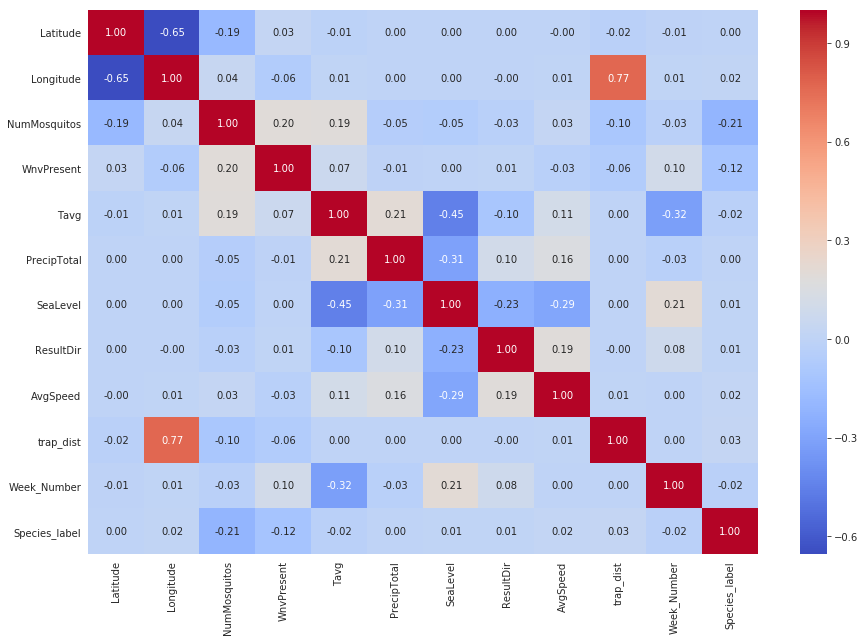

In [138]:
list_float = df.select_dtypes(exclude=['object']).columns

fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
cm_df = sns.heatmap(df[list_float].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126706 entries, 0 to 126798
Data columns (total 16 columns):
Date              126706 non-null datetime64[ns]
Latitude          126706 non-null float64
Longitude         126706 non-null float64
NumMosquitos      10413 non-null float64
Species           126706 non-null object
Trap              126706 non-null object
WnvPresent        10413 non-null float64
Tavg              126706 non-null float64
PrecipTotal       126706 non-null float64
SeaLevel          126706 non-null float64
ResultDir         126706 non-null float64
AvgSpeed          126706 non-null float64
WnvPresent_str    10413 non-null object
trap_dist         126706 non-null float64
Week_Number       126706 non-null int64
Species_label     126706 non-null int8
dtypes: datetime64[ns](1), float64(10), int64(1), int8(1), object(3)
memory usage: 20.6+ MB


In [140]:
def print_corr(df, label):
    y = df[label]
    list_float = df.select_dtypes(exclude=['object']).columns.tolist()
    list_float.remove('Date')
    
    linear_corr = pd.DataFrame()
# Pearson coefficients
    for col in list_float:
        linear_corr.loc[col, 'pearson_corr'] = df[col].corr(y) 
    
    linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])
    linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
    linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
    linear_corr.reset_index(inplace=True)
    return linear_corr 

In [141]:
print('The factors to be most relevant to mosquito pupulations are:')
print_corr(df, 'NumMosquitos')[1:]

The factors to be most relevant to mosquito pupulations are:


index  pearson_corr
1   Species_label     -0.211172
2      WnvPresent      0.196621
3            Tavg      0.191456
4        Latitude     -0.185226
5       trap_dist     -0.100797
6        SeaLevel     -0.053283
7     PrecipTotal     -0.050171
8       Longitude      0.038065
9       ResultDir     -0.026904
10       AvgSpeed      0.026834
11    Week_Number     -0.025093

In [142]:
print('The factors to be most relevant to WNV presence are:')
print_corr(df, 'WnvPresent')[1:]

The factors to be most relevant to WNV presence are:


index  pearson_corr
1    NumMosquitos      0.196621
2   Species_label     -0.120986
3     Week_Number      0.102092
4            Tavg      0.067092
5       trap_dist     -0.061941
6       Longitude     -0.060360
7        Latitude      0.029043
8        AvgSpeed     -0.026863
9       ResultDir      0.008030
10    PrecipTotal     -0.007099
11       SeaLevel      0.000805

## 5. Feature Engineering
<a id="featureeng"></a>

In [143]:
df.head()

Date   Latitude  Longitude  NumMosquitos                 Species  \
0 2007-05-29  41.954690 -87.800991           1.0  CULEX PIPIENS/RESTUANS   
1 2007-05-29  41.954690 -87.800991           1.0          CULEX RESTUANS   
2 2007-05-29  41.994991 -87.769279           1.0          CULEX RESTUANS   
3 2007-05-29  41.974089 -87.824812           1.0  CULEX PIPIENS/RESTUANS   
4 2007-05-29  41.974089 -87.824812           4.0          CULEX RESTUANS   

   Trap  WnvPresent  Tavg  PrecipTotal  SeaLevel  ResultDir  AvgSpeed  \
0  T002         0.0  74.0          0.0     30.11       18.0       6.5   
1  T002         0.0  74.0          0.0     30.11       18.0       6.5   
2  T007         0.0  74.0          0.0     30.11       18.0       6.5   
3  T015         0.0  74.0          0.0     30.11       18.0       6.5   
4  T015         0.0  74.0          0.0     30.11       18.0       6.5   

    WnvPresent_str  trap_dist  Week_Number  Species_label  
0  Wnv not present  -0.272072           22              1  
1  Wnv not present  -0.272072           22              2  
2  Wnv not present  -0.025062           22              2  
3  Wnv not present  -0.346565           22              1  
4  Wnv not present  -0.346565           22              2

In [144]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 3 columns that have missing values.


Missing Values  % of Total Values     type
NumMosquitos            116293               91.8  float64
WnvPresent              116293               91.8  float64
WnvPresent_str          116293               91.8   object

In [ ]:
#tmp  = ['Species', 'Trap', 'WnvPresent_str']
#drop_cols(cols=tmp)

In [145]:
df_train = df[df.notnull().all(axis=1)]
df_test = df[df.isnull().any(axis=1)]

In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10413 entries, 0 to 10505
Data columns (total 16 columns):
Date              10413 non-null datetime64[ns]
Latitude          10413 non-null float64
Longitude         10413 non-null float64
NumMosquitos      10413 non-null float64
Species           10413 non-null object
Trap              10413 non-null object
WnvPresent        10413 non-null float64
Tavg              10413 non-null float64
PrecipTotal       10413 non-null float64
SeaLevel          10413 non-null float64
ResultDir         10413 non-null float64
AvgSpeed          10413 non-null float64
WnvPresent_str    10413 non-null object
trap_dist         10413 non-null float64
Week_Number       10413 non-null int64
Species_label     10413 non-null int8
dtypes: datetime64[ns](1), float64(10), int64(1), int8(1), object(3)
memory usage: 1.3+ MB


In [147]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 10506 to 126798
Data columns (total 16 columns):
Date              116293 non-null datetime64[ns]
Latitude          116293 non-null float64
Longitude         116293 non-null float64
NumMosquitos      0 non-null float64
Species           116293 non-null object
Trap              116293 non-null object
WnvPresent        0 non-null float64
Tavg              116293 non-null float64
PrecipTotal       116293 non-null float64
SeaLevel          116293 non-null float64
ResultDir         116293 non-null float64
AvgSpeed          116293 non-null float64
WnvPresent_str    0 non-null object
trap_dist         116293 non-null float64
Week_Number       116293 non-null int64
Species_label     116293 non-null int8
dtypes: datetime64[ns](1), float64(10), int64(1), int8(1), object(3)
memory usage: 14.3+ MB


In [148]:
df_test.drop(['WnvPresent', 'NumMosquitos', 'WnvPresent_str'], axis=1, inplace=True)

Leave the test data alone, only work on the training data. 

In [149]:
df_train2 = df_train

In [150]:
df_train2.head()

Date   Latitude  Longitude  NumMosquitos                 Species  \
0 2007-05-29  41.954690 -87.800991           1.0  CULEX PIPIENS/RESTUANS   
1 2007-05-29  41.954690 -87.800991           1.0          CULEX RESTUANS   
2 2007-05-29  41.994991 -87.769279           1.0          CULEX RESTUANS   
3 2007-05-29  41.974089 -87.824812           1.0  CULEX PIPIENS/RESTUANS   
4 2007-05-29  41.974089 -87.824812           4.0          CULEX RESTUANS   

   Trap  WnvPresent  Tavg  PrecipTotal  SeaLevel  ResultDir  AvgSpeed  \
0  T002         0.0  74.0          0.0     30.11       18.0       6.5   
1  T002         0.0  74.0          0.0     30.11       18.0       6.5   
2  T007         0.0  74.0          0.0     30.11       18.0       6.5   
3  T015         0.0  74.0          0.0     30.11       18.0       6.5   
4  T015         0.0  74.0          0.0     30.11       18.0       6.5   

    WnvPresent_str  trap_dist  Week_Number  Species_label  
0  Wnv not present  -0.272072           22              1  
1  Wnv not present  -0.272072           22              2  
2  Wnv not present  -0.025062           22              2  
3  Wnv not present  -0.346565           22              1  
4  Wnv not present  -0.346565           22              2

Text(0.5, 1.0, 'Number of traps per Year')

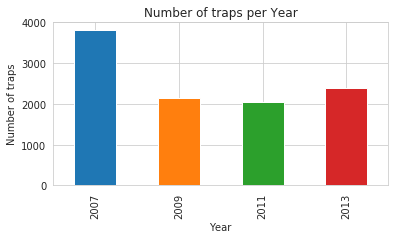

In [151]:
plt.figure(figsize=(6,3))
df_train2['Date'].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel('Year')
plt.ylabel('Number of traps')
plt.title('Number of traps per Year')

In [152]:
df_train2_train = df_train2.loc[df_train2['Date']  < df_train2['Date'].quantile(0.8)]
df_train2_test =  df_train2.loc[df_train2['Date'] >= df_train2['Date'].quantile(0.8)]

In [153]:
df_train2_train.head()

Date   Latitude  Longitude  NumMosquitos                 Species  \
0 2007-05-29  41.954690 -87.800991           1.0  CULEX PIPIENS/RESTUANS   
1 2007-05-29  41.954690 -87.800991           1.0          CULEX RESTUANS   
2 2007-05-29  41.994991 -87.769279           1.0          CULEX RESTUANS   
3 2007-05-29  41.974089 -87.824812           1.0  CULEX PIPIENS/RESTUANS   
4 2007-05-29  41.974089 -87.824812           4.0          CULEX RESTUANS   

   Trap  WnvPresent  Tavg  PrecipTotal  SeaLevel  ResultDir  AvgSpeed  \
0  T002         0.0  74.0          0.0     30.11       18.0       6.5   
1  T002         0.0  74.0          0.0     30.11       18.0       6.5   
2  T007         0.0  74.0          0.0     30.11       18.0       6.5   
3  T015         0.0  74.0          0.0     30.11       18.0       6.5   
4  T015         0.0  74.0          0.0     30.11       18.0       6.5   

    WnvPresent_str  trap_dist  Week_Number  Species_label  
0  Wnv not present  -0.272072           22              1  
1  Wnv not present  -0.272072           22              2  
2  Wnv not present  -0.025062           22              2  
3  Wnv not present  -0.346565           22              1  
4  Wnv not present  -0.346565           22              2

In [154]:
X_train = df_train2_train.drop(['Date', 'WnvPresent', 'NumMosquitos', 'Latitude', 'Longitude', 'Species', 'Trap', 'WnvPresent_str'], axis=1)
y_train = df_train2_train.loc[:, 'WnvPresent']

X_test = df_train2_test.drop(['Date', 'WnvPresent', 'NumMosquitos', 'Latitude', 'Longitude', 'Species', 'Trap', 'WnvPresent_str'], axis=1)
y_test = df_train2_test['WnvPresent']

In [156]:
X_train.head()

Tavg  PrecipTotal  SeaLevel  ResultDir  AvgSpeed  trap_dist  Week_Number  \
0  74.0          0.0     30.11       18.0       6.5  -0.272072           22   
1  74.0          0.0     30.11       18.0       6.5  -0.272072           22   
2  74.0          0.0     30.11       18.0       6.5  -0.025062           22   
3  74.0          0.0     30.11       18.0       6.5  -0.346565           22   
4  74.0          0.0     30.11       18.0       6.5  -0.346565           22   

   Species_label  
0              1  
1              2  
2              2  
3              1  
4              2

In [157]:
X_train.corr()

Tavg  PrecipTotal  SeaLevel  ResultDir  AvgSpeed  \
Tavg           1.000000     0.111527 -0.361224   0.095992 -0.080117   
PrecipTotal    0.111527     1.000000 -0.314787   0.028150  0.217241   
SeaLevel      -0.361224    -0.314787  1.000000  -0.252709 -0.311773   
ResultDir      0.095992     0.028150 -0.252709   1.000000  0.316791   
AvgSpeed      -0.080117     0.217241 -0.311773   0.316791  1.000000   
trap_dist      0.079722     0.020851  0.016301   0.007216  0.007181   
Week_Number    0.004149    -0.034162  0.339575   0.157491 -0.048683   
Species_label -0.133169    -0.011844 -0.017541   0.010808  0.050850   

               trap_dist  Week_Number  Species_label  
Tavg            0.079722     0.004149      -0.133169  
PrecipTotal     0.020851    -0.034162      -0.011844  
SeaLevel        0.016301     0.339575      -0.017541  
ResultDir       0.007216     0.157491       0.010808  
AvgSpeed        0.007181    -0.048683       0.050850  
trap_dist       1.000000     0.070544      -0.046558  
Week_Number     0.070544     1.000000      -0.257373  
Species_label  -0.046558    -0.257373       1.000000

#### One-hot encoding

In [159]:
df_train3 = df_train
df_train3 = pd.get_dummies(df_train3, columns=['Species'], drop_first=True)

In [163]:
df_train3_train = df_train3.loc[df_train3['Date']  < df_train3['Date'].quantile(0.8)]
df_train3_test =  df_train3.loc[df_train3['Date'] >= df_train3['Date'].quantile(0.8)]

In [164]:
df_train3_train.head()

Date   Latitude  Longitude  NumMosquitos  Trap  WnvPresent  Tavg  \
0 2007-05-29  41.954690 -87.800991           1.0  T002         0.0  74.0   
1 2007-05-29  41.954690 -87.800991           1.0  T002         0.0  74.0   
2 2007-05-29  41.994991 -87.769279           1.0  T007         0.0  74.0   
3 2007-05-29  41.974089 -87.824812           1.0  T015         0.0  74.0   
4 2007-05-29  41.974089 -87.824812           4.0  T015         0.0  74.0   

   PrecipTotal  SeaLevel  ResultDir  AvgSpeed   WnvPresent_str  trap_dist  \
0          0.0     30.11       18.0       6.5  Wnv not present  -0.272072   
1          0.0     30.11       18.0       6.5  Wnv not present  -0.272072   
2          0.0     30.11       18.0       6.5  Wnv not present  -0.025062   
3          0.0     30.11       18.0       6.5  Wnv not present  -0.346565   
4          0.0     30.11       18.0       6.5  Wnv not present  -0.346565   

   Week_Number  Species_label  Species_CULEX PIPIENS  \
0           22              1                      0   
1           22              2                      0   
2           22              2                      0   
3           22              1                      0   
4           22              2                      0   

   Species_CULEX PIPIENS/RESTUANS  Species_CULEX RESTUANS  \
0                               1                       0   
1                               0                       1   
2                               0                       1   
3                               1                       0   
4                               0                       1   

   Species_CULEX SALINARIUS  Species_CULEX TARSALIS  Species_CULEX TERRITANS  
0                         0                       0                        0  
1                         0                       0                        0  
2                         0                       0                        0  
3                         0                       0                        0  
4                         0                       0                        0

In [166]:
X_train3 = df_train3_train.drop(['Date', 'WnvPresent', 'NumMosquitos', 'Latitude', 'Longitude',  'Trap', 'WnvPresent_str','Species_label'], axis=1)
y_train3 = df_train3_train.loc[:, 'WnvPresent']

X_test3 = df_train3_test.drop(['Date', 'WnvPresent', 'NumMosquitos', 'Latitude', 'Longitude', 'Trap', 'WnvPresent_str','Species_label'], axis=1)
y_test3 = df_train3_test['WnvPresent']

In [167]:
X_train3.head(2)

Tavg  PrecipTotal  SeaLevel  ResultDir  AvgSpeed  trap_dist  Week_Number  \
0  74.0          0.0     30.11       18.0       6.5  -0.272072           22   
1  74.0          0.0     30.11       18.0       6.5  -0.272072           22   

   Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                               0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                       0                         0                       0   
1                       1                         0                       0   

   Species_CULEX TERRITANS  
0                        0  
1                        0

## Feature Scaling

As features are measured in different units, they cover different ranges. Some ML models, such as SVM, KNN that take into account distance measures between observations are therefore significantly affected by the range of the features and scaling allows them to learn. While some methods, such as Linear Regression and Ransom Forest do not actually require feature scaling, it's still best practice to take this step when we are comparing multiple algorithms.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [168]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)




scaler.fit(X_train3)

# Transform both training and testing data
X_train3 = pd.DataFrame(scaler.transform(X_train3), columns=X_train3.columns)
X_test3 = pd.DataFrame(scaler.transform(X_test3), columns=X_test3.columns)

## PCA visualization of the train data

I'm going to do a PCA analysis to check whether we can find the combinations of variables that explain the most variance. I will use a 2D PCA projection to visualize the entire dataset. I will plot different classes using different colors and check whether the classes are well-separated from each other.

In [169]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train.values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [170]:
principalDf.head(5)

principal component 1  principal component 2
0               0.521348               1.323524
1               0.445834               2.030223
2               0.439133               1.832957
3               0.523369               1.383015
4               0.447855               2.089713

In [171]:
y_train_df = pd.DataFrame(data=y_train.values, columns=['WnvPresent'])

In [172]:
finalDf = pd.concat([principalDf, y_train_df], axis = 1)
finalDf.head(5)

principal component 1  principal component 2  WnvPresent
0               0.521348               1.323524         0.0
1               0.445834               2.030223         0.0
2               0.439133               1.832957         0.0
3               0.523369               1.383015         0.0
4               0.447855               2.089713         0.0

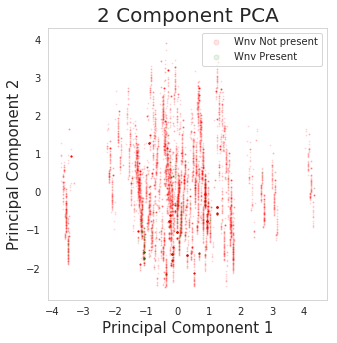

In [173]:
# visualize the PCA
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['WnvPresent'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1, alpha=0.1)
ax.legend(['Wnv Not present', 'Wnv Present'], markerscale=5.)
ax.grid()


In [174]:
pca.explained_variance_ratio_


array([0.23316679, 0.17142808])

## Linear dependence of WnvPresent

In [175]:
linear_corr = pd.DataFrame()

In [176]:
# Pearson coefficients
for col in X_train.columns:
    linear_corr.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

In [177]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)

In [178]:
linear_corr.reset_index(inplace=True)

In [179]:
linear_corr

index  pearson_corr
0  Species_label     -0.114172
1    Week_Number      0.085874
2           Tavg      0.072934
3       SeaLevel     -0.042981
4       AvgSpeed     -0.035345
5    PrecipTotal      0.019754
6      ResultDir     -0.014698
7      trap_dist      0.011642

## 6. Modeling 
<a id="modeling"></a>

I will implement the ML pipeline with Dimension reduction and the chosen model
The following models are evaluated, with stratified Kfold cross validation procedure* and grid search.

- Logistic regression with SGD training
- Random Forest
- XGBoost

Metrics: AUROC, confusion matrix
As we have an unbalanced dataset problem and we care accuracy of one class over other(false-positives, falsely predictions of the presence of WNV) are not so bad definitely do not want any false negatives (predict to be safe but WNV present), we could display the class accuracies in confusion matrices.

*I am using Stratified K Fold because there the classes are unbalanced. I do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).



In [ ]:
# CV model with Kfold stratified cross val
kfold = 3
random_state = 42

### 6.1 K-Fold Cross-Validation
<a id="kfold"></a>

I compare 11 of the most popular classifiers and evaluate their performance using a stratified kfold cross validation procedure.

-Logistic Regression
-Linear Discriminant Analysis
-SVM
-KNN
-Random Forest 
-Decision Tree
-Extra Trees (ExtC)
-AdaBoost (Ada)
-Gradient Boosting (GBC)
-Multiple layer perceptron (neural network)
-XGBoost

In [180]:
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import  XGBClassifier

In [181]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

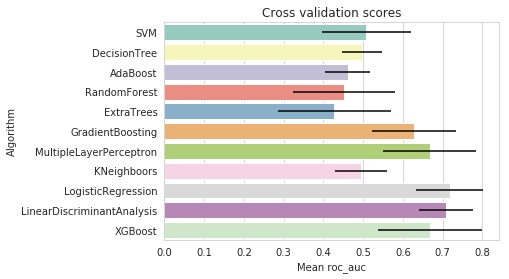

In [182]:
# Test differents algorithms 
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVM","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBoost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean roc_auc")
g = g.set_title("Cross validation scores")

### 6.2 Hypeparameter tunning 
<a id="hyper"></a>


#### Logistic Regression with SGD

In [183]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [184]:
pipeline_sgdlr = Pipeline([
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=random_state, warm_start=False))
])

In [185]:
param_grid_sgdlr  = {
    'model__alpha': [10**-5, 10**-1, 10**2],
    'model__penalty': ['l1', 'l2']
}

In [186]:
grid_sgdlr = GridSearchCV(estimator=pipeline_sgdlr, param_grid=param_grid_sgdlr, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [187]:
grid_sgdlr.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__penalty': ['l1', 'l2'], 'model__alpha': [1e-05, 0.1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [188]:
sgdlr_estimator = grid_sgdlr.best_estimator_
print('Best score: ', grid_sgdlr.best_score_)
print('Best parameters set: \n', grid_sgdlr.best_params_)


Best score:  0.710529607404291
Best parameters set: 
 {'model__penalty': 'l1', 'model__alpha': 1e-05}


In [189]:
y_pred_sgdlr = sgdlr_estimator.predict(X_test)
y_prob_sgdlr = sgdlr_estimator.predict_proba(X_test)[:,1]

In [190]:
y_train_pred_sgdlr = sgdlr_estimator.predict(X_train)
y_train_prob_sgdlr = sgdlr_estimator.predict_proba(X_train)[:,1]

**Feature Coefficients in the Logistic Regress Model**

In [191]:
LRmodel_l2 = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=random_state, warm_start=False, alpha=0.1, penalty='l2')

In [192]:
LRmodel_l2.fit(X_train, y_train)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [193]:
temp = sorted(zip(np.round(LRmodel_l2.coef_.reshape(-1),3), X_train.columns.values), key=lambda x: -abs(x[0]))
weight = [x for x, _ in temp]
feature = [x for _, x in temp]

In [194]:
print("Logistic Regression (L2) Coefficients: Top 10")
pd.DataFrame({'weight': weight}, index = feature).head(10)

Logistic Regression (L2) Coefficients: Top 10


weight
Species_label  -0.157
Week_Number     0.118
Tavg            0.113
SeaLevel       -0.066
trap_dist      -0.066
AvgSpeed       -0.056
PrecipTotal     0.024
ResultDir      -0.002

#### One Hot encoding

In [195]:
sgdlr3 = grid_sgdlr.fit(X_train3, y_train3)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [196]:
sgdlr_estimator3 = sgdlr3.best_estimator_
print('Best score: ', sgdlr3.best_score_)
print('Best parameters set: \n', sgdlr3.best_params_)


Best score:  0.7082254081638262
Best parameters set: 
 {'model__penalty': 'l2', 'model__alpha': 0.1}


### KNN
I need to reduce the number of the features for KNN (<10) for better performance (reference at wikipedia)

I use LDA for dimension reduction

In [197]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn import decomposition

In [198]:
pipeline_knn2 = Pipeline([
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))   
])

In [199]:
param_grid_knn2 = {
    'lda__n_components': range(3,6),
    'model__n_neighbors': [5, 25, 125]
}

In [200]:
grid_knn2 = GridSearchCV(estimator=pipeline_knn2, param_grid=param_grid_knn2, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [201]:
grid_knn2.fit(X_train3, y_train3)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lda__n_components': range(3, 6), 'model__n_neighbors': [5, 25, 125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [202]:
knn_estimator2 = grid_knn2.best_estimator_
print('Best score: ', grid_knn2.best_score_)
print('Best parameters set: \n', grid_knn2.best_params_)

Best score:  0.6818948659186174
Best parameters set: 
 {'lda__n_components': 3, 'model__n_neighbors': 125}


Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression.

In [204]:
y_pred_knn = knn_estimator2.predict(X_test3)
y_prob_knn = knn_estimator2.predict_proba(X_test3)[:,1]

In [205]:
y_train_pred_knn = knn_estimator2.predict(X_train3)
y_train_prob_knn = knn_estimator2.predict_proba(X_train3)[:,1]


#### Random Forest

In [206]:
from sklearn.ensemble import RandomForestClassifier

In [207]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=random_state,max_features='sqrt') 
param_grid_rf = {
    'n_estimators': [100, 150], 
    'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3},{0:1, 1:4} ,{0:1, 1:5}, {0:1, 1:6}, {0:1, 1:7}], #'model__class_weight': [{0:1, 1:1}, {0:1,1:2}, {0:1, 1:3}, {0:1, 1:4}]
    #'model__min_samples_split':[2,3]
    'max_features':[2,3,4,5],
    "max_depth":range(2,7)
}

In [208]:
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='roc_auc',n_jobs=-1,pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [209]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  3.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(2, 7), 'max_features': [2, 3, 4, 5], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 6}, {0: 1, 1: 7}], 'n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [210]:
rf_estimator = grid_rf.best_estimator_
print('Best score: ', grid_rf.best_score_)
print('Best parameters set: \n', grid_rf.best_params_)

Best score:  0.733874091131653
Best parameters set: 
 {'max_depth': 2, 'max_features': 5, 'n_estimators': 150, 'class_weight': {0: 1, 1: 6}}


In [211]:
y_pred_rf = rf_estimator.predict(X_test)
y_prob_rf = rf_estimator.predict_proba(X_test)[:,1]

In [212]:
y_train_pred_rf = rf_estimator.predict(X_train)
y_train_prob_rf = rf_estimator.predict_proba(X_train)[:,1]

**Feature importance**

In [213]:
names = list(X_train)


In [214]:
feature_importances = pd.DataFrame(grid_rf.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                  ascending=False)

In [215]:
print("Features sorted by their score: Top 10")
feature_importances.head(10)

Features sorted by their score: Top 10


importance
Week_Number      0.638500
Tavg             0.120113
SeaLevel         0.115582
Species_label    0.081706
PrecipTotal      0.020919
AvgSpeed         0.011568
ResultDir        0.009414
trap_dist        0.002198

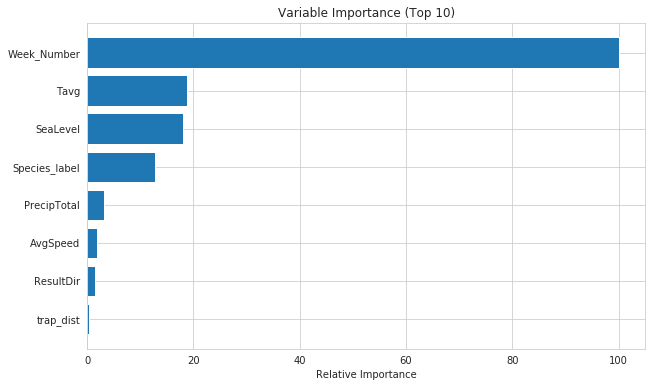

In [216]:
# Normalize The Features and visulize the top 10 features
%matplotlib inline
feature_importance = 100.0 * (grid_rf.best_estimator_.feature_importances_ / grid_rf.best_estimator_.feature_importances_.max())
sorted_idx = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i])[-10:]
pos = np.arange(len(sorted_idx)) + .5
plt.figure(figsize=(10, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.asanyarray(X_train.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Top 10)')
plt.show()

#### Gradient Boosting

In [217]:
# Gradient boosting tunning
gb = GradientBoostingClassifier(random_state=random_state)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

grid_gb = GridSearchCV(gb,param_grid = gb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_gb.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.1s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  1.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [4, 8], 'n_estimators': [100, 200, 300], 'loss': ['deviance'], 'max_features': [0.3, 0.1], 'learning_rate': [0.1, 0.05, 0.01], 'min_samples_leaf': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [218]:
gb_best = grid_gb.best_estimator_
# Best score
print('Best Score:', grid_gb.best_score_)
print('Best parameters set: \n', grid_gb.best_params_)

Best Score: 0.6889070887562335
Best parameters set: 
 {'max_depth': 4, 'n_estimators': 100, 'loss': 'deviance', 'max_features': 0.3, 'learning_rate': 0.01, 'min_samples_leaf': 150}


In [219]:
y_pred_gb = gb_best.predict(X_test)
y_prob_gb = gb_best.predict_proba(X_test)[:,1]

#### XGBoost

In [220]:
# XGboost tunning
xgb = GradientBoostingClassifier(random_state=random_state)

#xgb.get_params().keys()
xgb_param_grid = {
    'learning_rate': [0.025,0.05,0.1], 
    'max_depth': [3,4,5],
    'subsample': [0.25,0.5,1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid = xgb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

grid_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   30.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [3, 4, 5], 'learning_rate': [0.025, 0.05, 0.1], 'subsample': [0.25, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [221]:
xgb_best = grid_xgb.best_estimator_
# Best score
print('Best Score:', grid_xgb.best_score_)
print('Best parameters set: \n', grid_xgb.best_params_)

Best Score: 0.6520078322224112
Best parameters set: 
 {'max_depth': 3, 'learning_rate': 0.025, 'subsample': 1.0}


In [222]:
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:,1]

In [223]:
# print a summary of the scores
def print_grid_search_metrics(gs):
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Comparing the best models
I will take a closer look of the selected models: logistic Regression, Random Forest, Gradient Boosting, KNN, XGBoost and SVM.

- Learning Curve
- Confusion Matrix

**Plot learning curves**

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [224]:
# Plot learning curves
#grid_svm, grid_rf, grid_gb, grid_knn, grid_lr, grid_xgb

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


#g = plot_learning_curve(grid_rf.best_estimator_,"Random Forest learning curves",X_train,y_train,cv=kfold)
#g = plot_learning_curve(grid_gb.best_estimator_,"Gradient Boosting learning curves",X_train,y_train,cv=kfold)
#g = plot_learning_curve(grid_knn2.best_estimator_,"KNN learning curves",X_train,y_train,cv=kfold)
#g = plot_learning_curve(grid_sgdlr.best_estimator_,"Logistic Regression learning curves",X_train,y_train,cv=kfold)
#g = plot_learning_curve(grid_xgb.best_estimator_,"XGBoost learning curves",X_train,y_train,cv=kfold)


Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [225]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

def cal_evaluation(classifier, cm, auc):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2 * precision * recall / (precision + recall)
    print(classifier)
    print("Accuracy is " + str(accuracy))
    print("Precision is " + str(precision))
    print("Recall is " + str(recall))
    print("F1 score is " + str(f1))
    print("ROC AUC is " + str(auc))
    
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        cal_evaluation(classifier, cm, auc)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for {}'.format(classifier))
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [226]:
%matplotlib inline

y = np.array(df_train2_train.WnvPresent.values)
class_names = np.unique(y)
print(class_names)

confusion_matrices = [
    ("Gradient Boosting", confusion_matrix(y_test, y_pred_gb), roc_auc_score(y_test, y_prob_gb)),
    ("Logisitic Regression", confusion_matrix(y_test, y_pred_sgdlr), roc_auc_score(y_test, y_prob_sgdlr)),
    ("K-Nearest-Neighbors", confusion_matrix(y_test, y_pred_knn), roc_auc_score(y_test, y_prob_knn)),
    ("Random Forest", confusion_matrix(y_test, y_pred_rf), roc_auc_score(y_test, y_prob_rf)),
    ("XGBoost Classifier", confusion_matrix(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb))
    
]

#draw_confusion_matrices(confusion_matrices)

[0. 1.]


In [227]:
def evaluation(X_train, X_test, Y_train, Y_test, Y_train_pred, Y_train_prob, Y_pred, Y_prob):
    print("--- ROC AUC ---")
    print("Training Set:", roc_auc_score(Y_train, Y_train_prob))
    print("Test Set:", roc_auc_score(Y_test, Y_prob))
    
    print("\n--- Accuracy ---")
    print("Training Set:", accuracy_score(Y_train, Y_train_pred))
    print("Test Set:", accuracy_score(Y_test, Y_pred))

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    print("\n--- Confusion Matrix ---")
    print("True Positive:", tp)
    print("False Negative:", fn)
    print("True Negative:", tn)
    print("False Positive:", fp)

    print("\n--- Precision ---")
    print("Training Set:", precision_score(Y_train, Y_train_pred))
    print("Test Set:", precision_score(Y_test, Y_pred))

    print("\n--- Recall ---")
    print("Training Set:", recall_score(Y_train, Y_train_pred))
    print("Test Set:", recall_score(Y_test, Y_pred))

    print("\n--- F1 Score ---")
    print("Training Set:", f1_score(Y_train, Y_train_pred))
    print("Test Set:", f1_score(Y_test, Y_pred))
      
def plot_ROC(X_test, Y_test, Y_prob):
    
    #Y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(Y_test, Y_prob, pos_label=1)
    roc_auc = roc_auc_score(Y_test, Y_prob)
    # These are the points at threshold = 0.1~0.5
    x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
    x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

    fig = plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Area = {:.2f})'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()

===== Logistic Regression =====


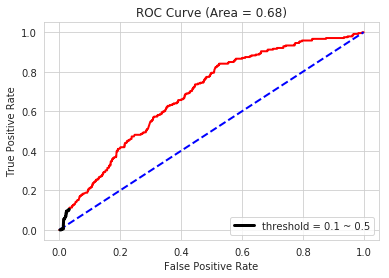

In [228]:
print('===== Logistic Regression =====')
#evaluation(X_train, X_test, y_train, y_test, y_train_pred_sgdlr, y_train_prob_sgdlr, y_pred_sgdlr, y_prob_sgdlr)
plot_ROC(X_test, y_test, y_prob_sgdlr)

===== KNN =====


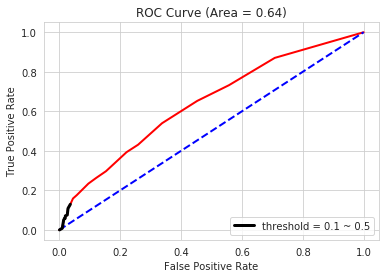

In [229]:
print('===== KNN =====')
#evaluation(X_train, X_test, y_train, y_test, y_train_pred_knn, y_train_prob_knn, y_pred_knn, y_prob_knn)
plot_ROC(X_test, y_test, y_prob_knn)

In [230]:
y_test.max()

1.0

===== Random Forest =====


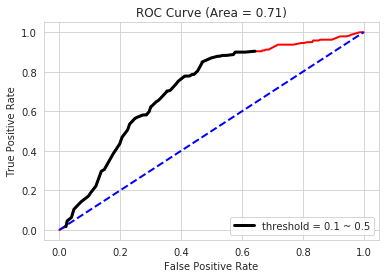

In [231]:
print('===== Random Forest =====')
#evaluation(X_train, X_test, y_train, y_test, y_train_pred_rf, y_train_prob_rf, y_pred_rf, y_prob_rf)
plot_ROC(X_test, y_test, y_prob_rf)

AUROC                Algorithm
0  0.708225  SGD Logistic Regression
1  0.733874             RandomForest
2  0.681895              KNeighboors
3  0.652008               XGBoosting

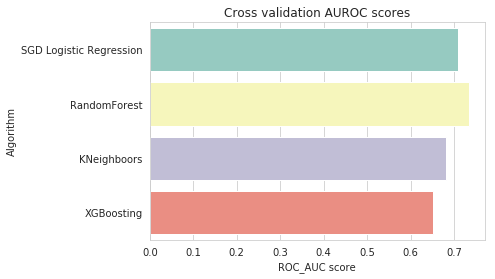

In [232]:
# plot the AUROC scores on the training dataset. 
auroc_means = [grid_sgdlr.best_score_, grid_rf.best_score_,grid_knn2.best_score_, grid_xgb.best_score_]
auroc_res = pd.DataFrame({"AUROC":auroc_means,"Algorithm":["SGD Logistic Regression",
"RandomForest","KNeighboors", "XGBoosting"]})

g = sns.barplot("AUROC","Algorithm", data = auroc_res, palette="Set3",orient = "h")
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation AUROC scores")
auroc_res

Next, I will try to determine the optimal threshold. As true positive rate and recall are actually equal, therefore, one can use a lower threshold(<0.5) to achieve higher recall rate

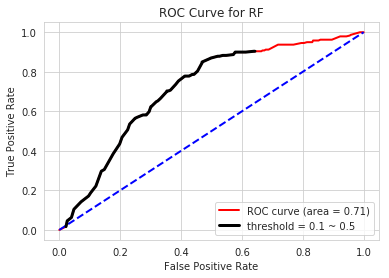

In [233]:
# make the ROC curve
fpr, tpr, thresh = roc_curve(y_test, y_prob_rf, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob_rf)

# These are the points at threshold = 0.1~0.5
x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

fig = plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF')
plt.legend(loc="lower right")
plt.show()

In [234]:
acc_grid = np.zeros(thresh.shape)
prec_grid = np.zeros(thresh.shape)
recall_grid = np.zeros(thresh.shape)
TP_grid = np.zeros(thresh.shape)
FP_grid = np.zeros(thresh.shape)
FN_grid = np.zeros(thresh.shape)

for i in range(thresh.shape[0]):
    cm = confusion_matrix(y_test, y_prob_rf >= thresh[i])
    acc_grid[i] = accuracy_score(y_test, y_prob_rf >= thresh[i])
    prec_grid[i] = precision_score(y_test, y_prob_rf >= thresh[i])
    recall_grid[i] = recall_score(y_test, y_prob_rf >= thresh[i])
    TP_grid[i] = cm[1][1]
    FP_grid[i] = cm[0][1]
    FN_grid[i] = cm[1][0]

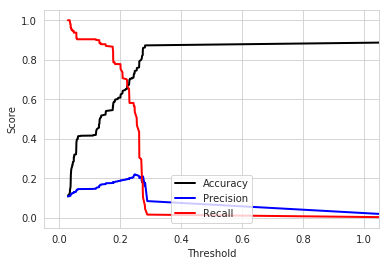

In [235]:
fig = plt.figure()
plt.plot(thresh, acc_grid, color='k', lw=2, label='Accuracy')
plt.plot(thresh, prec_grid, color='b', lw=2, label='Precision')
plt.plot(thresh, recall_grid, color='r', lw=2, label='Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc="lower center")
plt.show()


#### Oversampling

In [ ]:
#from imblearn.over_sampling import SMOTE

In [ ]:
#sm = SMOTE(random_state=42, ratio = 1.0)
#x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [ ]:
#clf_rf = RandomForestClassifier(n_estimators=150, class_weight= [0: 1, 1: 6], max_depth = 2, max_features =5, random_state=42)
#clf_rf.fit(x_train_res, y_train_res)

In [ ]:
"""
print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))
print('\nTest Results')
print(clf_rf.score(test_features, test_target))
print(recall_score(test_target, clf_rf.predict(test_features)))
"""

## 7. Conclusion
<a id="conclusion"></a>

I applied ML to predict the probability of WNV presence. After training with 4 models (Logistic Regression, random forest, XG Boosting and KNN), I found that Random Forest classifier performs the best (highest AUROC score of 0.82) and the score on the testing dataset is slightly lower at 0.71.

According to the Pearson correlation between the features and the target variable, the most important features for predicting WNV are: Species, Week, Temperature, 